<a href="https://colab.research.google.com/github/nishp99/RL-Perceptron/blob/main/RL_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.special
import math


In [2]:
def magnitude(n):
  if n % 2 == 0:
    a, b = n+1, n/2
    c = 1
    for i in range(int(n/2-1)):
      a, b = a-2, b-1
      c = c*a/(2*b)
    return np.sqrt(np.pi/2)*c
  else:
    a, b = (n+1)/2, n
    c = 1
    for i in range(int((n-1)/2)):
      a, b = a-1, b-2
      c = c*2*a/b
    return np.sqrt(2/np.pi)*c

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import copy
import glob
import math
import os.path

import numpy as np
import numpy.random as rnd

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import scipy
import scipy.special

plt.rc("font", **{"size": 20})
plt.rc("lines", linewidth=4.0)
mpl.rcParams['lines.markersize'] = 20
mpl.rcParams['lines.markeredgewidth'] = 2

fig_size = 6

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
"""
We draw one teacher from the hypersphere in D dimensions and normalise its weight vector.
"""

# input dimension
D = 400


# Choose a random teacher
w_teacher = rnd.randn(D)
w_teacher /= np.sqrt(w_teacher @ w_teacher / D)

def test_accuracy(w_stu, w_tea, T):
    """
    Returns the test accuracy for a teacher-student pair with the given weight vectors.
    """
    angle = (w_stu @ w_tea / 
             np.linalg.norm(w_stu) / np.linalg.norm(w_tea))
    return (1 - 1 / np.pi * np.arccos(angle))**T

def test_accuracy_op(Q, R, T):
    """
    Returns the test accuracy for a teacher-student pair with the given overlaps.
    """
    return (1 - 1 / np.pi * np.arccos(R * np.sqrt(D/Q)/W))**T

def incorrect(w_stu, w_tea):
  angle = (w_stu @ w_tea / 
             np.linalg.norm(w_stu) / np.linalg.norm(w_tea))
  return angle/np.pi


In [5]:
unit_teacher = w_teacher/np.linalg.norm(w_teacher)
W = np.linalg.norm(w_teacher)

In [ ]:
"""
Experimentation: original case
"""

Ts = [12]
# student weight vectors
std0 = 1  # std dev of the initial student weights.

w_rl_student = dict()
w_student = rnd.randn(D)
for T in Ts:
    w_rl_student[T] = w_student.copy()
    
# learning rates
lr = 1

# make a copy of the initial conditions of the students for 
# later comparisons with the ODE integration
w_rl_init = copy.deepcopy(w_rl_student)

step = 0
num_steps = 2500 * D

steps_rl_sim = []
accuracies_rl_sim = dict()
for T in Ts:
    accuracies_rl_sim[T] = []
R_rl_sim = copy.deepcopy(accuracies_rl_sim)
Q_rl_sim = copy.deepcopy(accuracies_rl_sim)

while step < num_steps:
    for T in Ts:
        # sample new input, output pair
        xs = rnd.randn(T, D)
        ys = np.sign(w_teacher @ xs.T)

        ypred = np.sign(w_rl_student[T] @ xs.T)

        reward = np.all(ys == ypred)

        hebbian_update = np.mean(ys[:, None] * xs, axis=0)

        w_rl_student[T] += lr / np.sqrt(D) * reward * hebbian_update
    
    if step % D == 0:
      steps_rl_sim += [step]
      for T in Ts:
          accuracies_rl_sim[T] += [test_accuracy(w_rl_student[T], w_teacher, T)]
          R_rl_sim[T] += [w_teacher @ w_rl_student[T] / D]
          Q_rl_sim[T] += [w_rl_student[T] @ w_rl_student[T] / D]
            
    step += 1

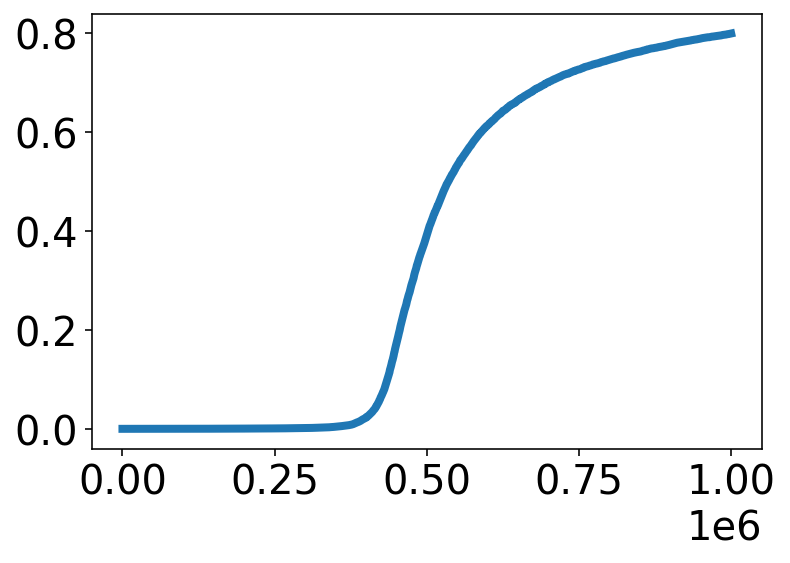

In [ ]:
plt.plot(steps_rl_sim, accuracies_rl_sim[12])

In [ ]:
D = 400

In [ ]:
"""
ODEs original
"""
Q = dict()
R = dict()
Q_s = dict()
R_s = dict()
Q_f = dict()
R_f = dict()
w = copy.deepcopy(w_rl_init)

# Initial conditions for the order parameters
for T in Ts:
    Q[T] = w_rl_init[T] @ w_rl_init[T] / D
    R[T] = w_rl_init[T] @ w_teacher / D
    Q_s[T] = w_rl_init[T] @ w_rl_init[T] / D
    R_s[T] = w_rl_init[T] @ w_teacher / D
    Q_f[T] = w_rl_init[T] @ w_rl_init[T] / D
    R_f[T] = w_rl_init[T] @ w_teacher / D

# Integrate equations of motion
step = 0
steps_rl_ode = []
accuracies_rl_ode = dict()
accuracies_rl_ode_s = dict()
accuracies_rl_ode_f = dict()
#accuracies_w_update = dict()
for T in Ts:
    accuracies_rl_ode[T] = []
    accuracies_rl_ode_s[T] = []
    accuracies_rl_ode_f[T] = []
    #accuracies_w_update[T] = []
R_rl_ode = copy.deepcopy(accuracies_rl_ode)    
Q_rl_ode = copy.deepcopy(accuracies_rl_ode)
R_rl_ode_s = copy.deepcopy(accuracies_rl_ode)    
Q_rl_ode_s = copy.deepcopy(accuracies_rl_ode)
R_rl_ode_f = copy.deepcopy(accuracies_rl_ode)    
Q_rl_ode_f = copy.deepcopy(accuracies_rl_ode)

dt = 1 / D

while step < num_steps:
    for T in Ts:
        # compute the probability that one, all-but-one, or all predictions were correct
        p_correct = (1 - 1 / np.pi * np.arccos(R[T] / W *np.sqrt(D/Q[T])))
        p_correct_all = p_correct**T
        unit_student = w[T]/np.linalg.norm(w[T])
        #phi_2 = (np.pi - np.arccos(unit_student@unit_teacher))/2
        phi_1 = (np.pi - np.arccos(R[T] / W *np.sqrt(D/Q[T])))/2

        C_1 = np.sqrt(np.pi/2)*np.sin(phi_1)/phi_1
        #C_2 = np.sqrt(np.pi/2)*np.sin(phi_2)/phi_2
        
        half_overlap = np.sqrt(1 + R[T]/W * np.sqrt(D/Q[T]))

        dR = lr * W*C_1/np.sqrt(2*D) * p_correct_all * half_overlap
        
        dQ = lr * (np.sqrt(2)* C_1 * np.sqrt(Q[T]) * half_overlap + lr/T + 2*lr*(T-1)*C_1**2/(D*T))*p_correct_all
        
        #dw = lr * np.sqrt(D)*C_2*test_accuracy(w[T], w_teacher, T) * (unit_teacher + unit_student)/np.linalg.norm(unit_teacher + unit_student)
        
        """dR = 1 / np.sqrt(2 * np.pi) * (1 + R[T] / np.sqrt(Q[T])) * p_correct_others
        dQ = (np.sqrt(2 / np.pi) * (np.sqrt(Q[T]) + R[T]) * p_correct_others
              + lr / T * p_correct_all)"""
        
        R[T] += dt * dR
        Q[T] += dt * dQ
        #w[T] += dt * dw

        p_c = (1 - 1 / np.pi * np.arccos(R_s[T] / np.sqrt(Q_s[T])))
        p_c_others = p_c**(T-1)
        p_c_all = p_c**T

        # 
        dR_s = 1 / np.sqrt(2 * np.pi) * (1 + R_s[T] / np.sqrt(Q_s[T])) * p_c_others
        dQ_s = (np.sqrt(2 / np.pi) * (np.sqrt(Q_s[T]) + R_s[T]) * p_c_others
              + lr / T * p_c_all)
        
        R_s[T] += dt * lr * dR_s
        Q_s[T] += dt * lr * dQ_s

        p_f = (1 - 1 / np.pi * np.arccos(R_f[T] / np.sqrt(Q_f[T])))
        p_f_others = p_f**(T-1)
        p_f_all = p_f**T

        dR_f = 1 / np.sqrt(2 * np.pi) * (1 + R_f[T] / np.sqrt(Q_f[T])) * p_f_others
        dQ_f = (np.sqrt(2 / np.pi) * (np.sqrt(Q_f[T]) + R_f[T]) * p_f_others
              + lr / (T*D) * (D*p_f**2 + (T-1)/np.pi*(1 + R_f[T] / np.sqrt(Q_f[T])))*p_f**(T-2))
      
        R_f[T] += dt * lr * dR_f
        Q_f[T] += dt * lr * dQ_f
        
    if step % D == 0:
      steps_rl_ode += [step]
      for T in Ts:
          accuracies_rl_ode[T] += [test_accuracy_op(Q[T], R[T], T)]
          accuracies_rl_ode_s[T] += [test_accuracy_op(Q_s[T], R_s[T], T)]
          accuracies_rl_ode_f[T] += [test_accuracy_op(Q_f[T], R_f[T], T)]
          #accuracies_w_update[T] += [test_accuracy(w[T], w_teacher, T)]
          R_rl_ode[T] += [R[T]]
          Q_rl_ode[T] += [Q[T]]
          R_rl_ode_s[T] += [R_s[T]]
          Q_rl_ode_s[T] += [Q_s[T]]
          R_rl_ode_f[T] += [R_f[T]]
          Q_rl_ode_f[T] += [Q_f[T]]

    step += 1


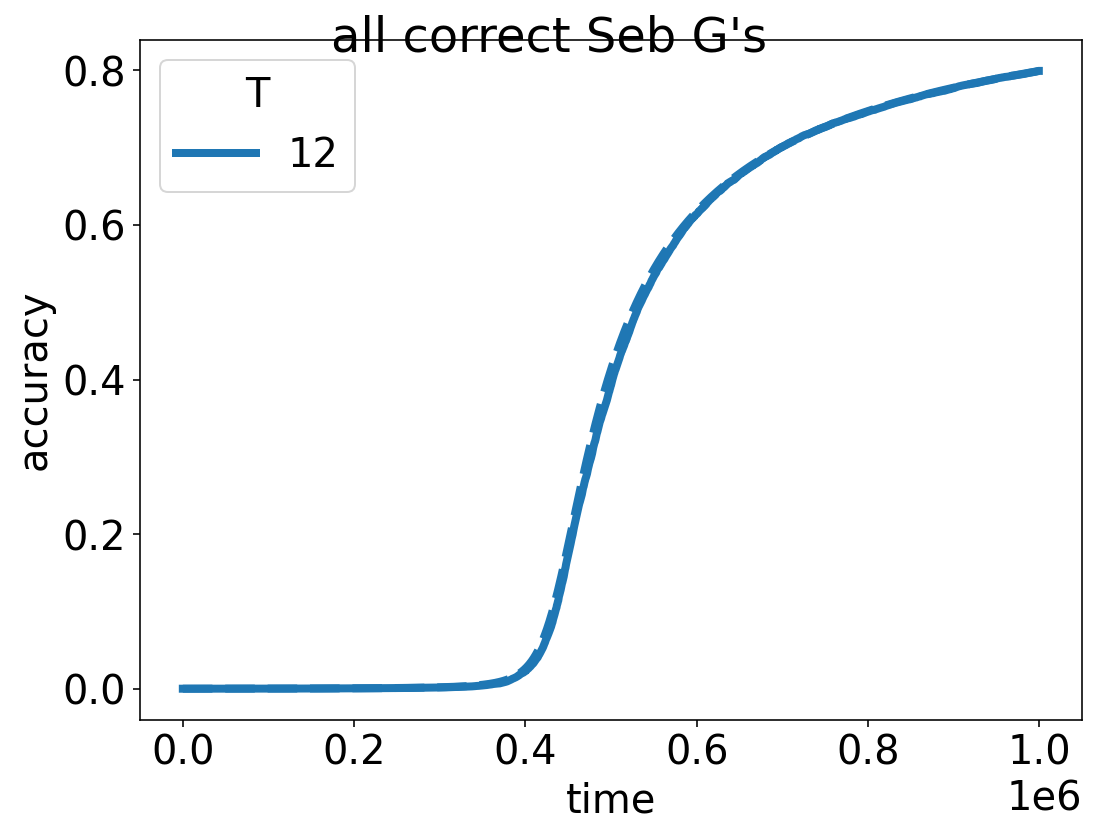

In [ ]:
fig, ax = plt.subplots(figsize=(4 /3 * fig_size, fig_size))
fig.suptitle("all correct Seb G's")
for algo_idx, algo in enumerate(w_rl_student.keys()):
    color = "C" + str(algo_idx)
    ax.plot(steps_rl_sim, accuracies_rl_sim[algo], label=algo, color=color)
    ax.plot(steps_rl_ode , accuracies_rl_ode_s[algo], "--", color=color)
ax.legend(title='T')
ax.set_xlabel("time")
ax.set_ylabel("accuracy")
# ax.set_ylim(top=1)
plt.tight_layout()
plt.show()

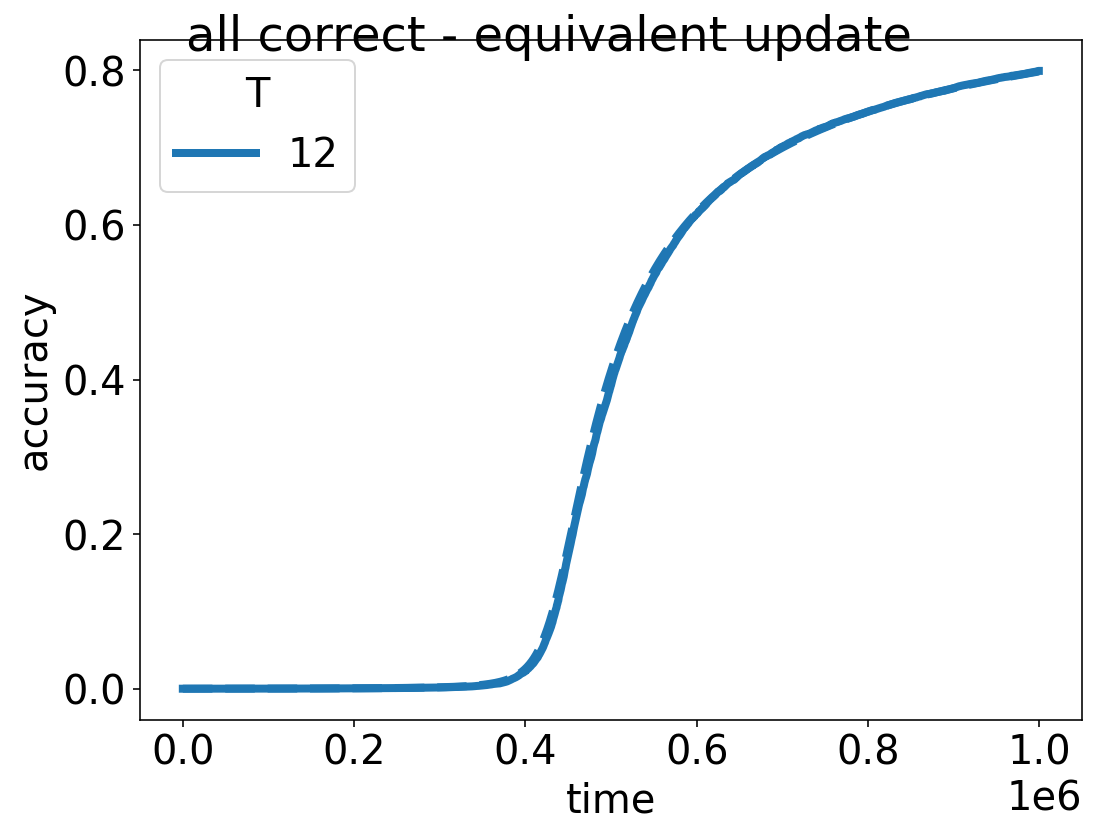

In [ ]:
fig, ax = plt.subplots(figsize=(4 /3 * fig_size, fig_size))
fig.suptitle("all correct - equivalent update")
for algo_idx, algo in enumerate(w_rl_student.keys()):
    color = "C" + str(algo_idx)
    ax.plot(steps_rl_sim, accuracies_rl_sim[algo], label=algo, color=color)
    ax.plot(steps_rl_ode , accuracies_rl_ode_f[algo], "--", color=color)
ax.legend(title='T')
ax.set_xlabel("time")
ax.set_ylabel("accuracy")
# ax.set_ylim(top=1)
plt.tight_layout()
plt.show()

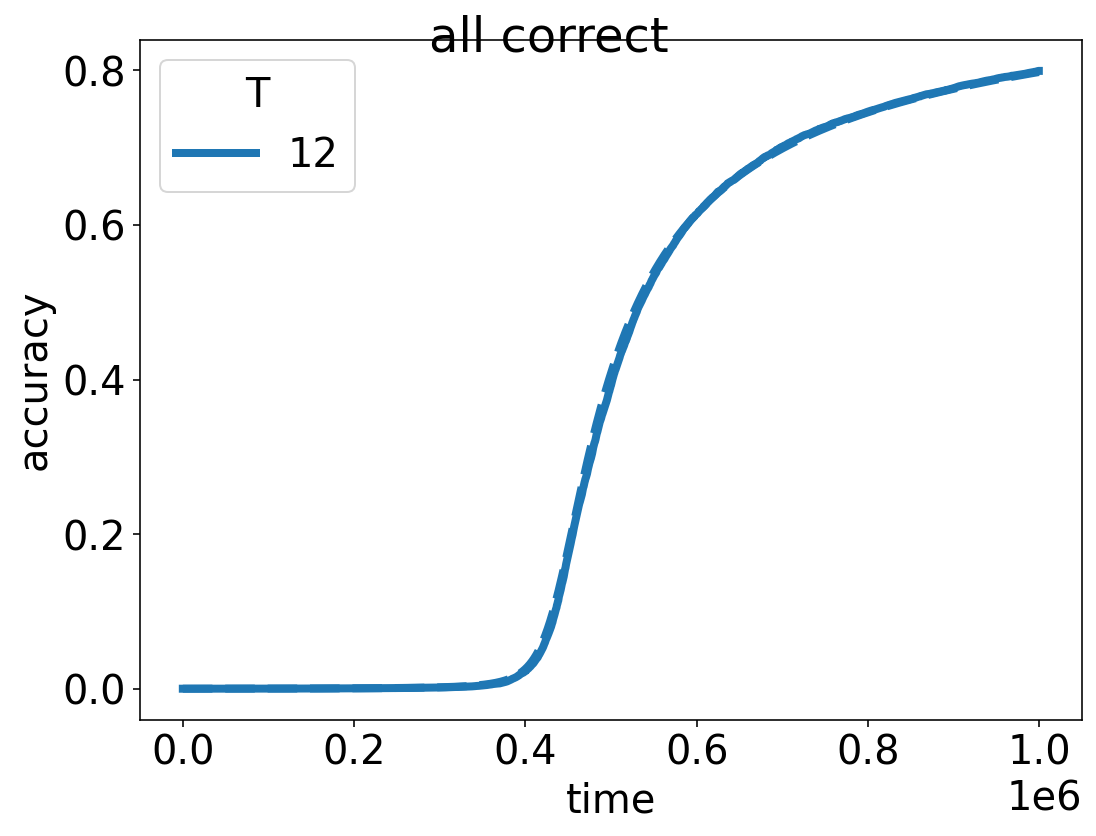

In [ ]:
fig, ax = plt.subplots(figsize=(4 /3 * fig_size, fig_size))
fig.suptitle("all correct")
for algo_idx, algo in enumerate(w_rl_student.keys()):
    color = "C" + str(algo_idx)
    ax.plot(steps_rl_sim, accuracies_rl_sim[algo], label=algo, color=color)
    ax.plot(steps_rl_ode , accuracies_rl_ode[algo], "--", color=color)
ax.legend(title='T')
ax.set_xlabel("time")
ax.set_ylabel("accuracy")
# ax.set_ylim(top=1)
plt.tight_layout()
plt.show()

In [ ]:
"""
expected[x*indicator(correct)]
"""
thetas = []
expected = []
analytic = []
sw_teacher = rnd.randn(400)
sw_teacher /= np.sqrt(w_teacher @ w_teacher / 400)
w_student = sw_teacher + rnd.randn(400)/160000
size = (np.linalg.norm(sw_teacher))
unit = sw_teacher/size

for i in range(100):
  theta = np.arccos(w_student @ unit/np.linalg.norm(w_student))
  thetas.append(theta)
  analytic.append(np.sin((np.pi-theta)/2)/(np.pi-theta))

  xs = rnd.randn(300000, 400)
  ys = np.sign(sw_teacher @ xs.T)

  ypred = np.sign(w_student @ xs.T)

  Y = ys*ypred
  Y += 1
  Y /= 2
  N = np.sum(Y)
  alt_x = Y[:, None] * ys[:,None] * xs
  #alt_x =  ys[:,None] * xs
  hebbian_update = np.sum(alt_x, axis=0)/N
  #hebbian_update = np.mean(alt_x, axis=0)
  expected.append(np.linalg.norm(hebbian_update))
  w_student += (w_student/np.linalg.norm(w_student) - unit)/np.linalg.norm(w_student/np.linalg.norm(w_student) - unit)

In [ ]:
p = 1 - np.arccos(w_student @ sw_teacher.T/(np.linalg.norm(sw_teacher)*np.linalg.norm(w_student)))/np.pi

In [ ]:
plt.plot(thetas, expected)
plt.plot(thetas, [np.sqrt(2*np.pi)*i for i in analytic])

In [ ]:
plt.plot(thetas, expected)
plt.plot(thetas, [2.5*i for i in analytic])

In [ ]:
D = 400

In [ ]:
"""
Experimentation with update rule: only update if got first n or more correct
"""
"""Ts = [3, 10]
ns = {3:[2,3], 10:[6,8,10]}"""

"""Ts_2 = [3,6,10,12]
ns = {3:[2], 6:[4],10:[6,9],12:[7,10]}
"""

Ts_2 = [10,12]
ns_2 = {10:[6,9],12:[7,10]}

# student weight vectors
std0 = 1  # std dev of the initial student weights.

w_rl_student_2 = dict()
w_student_2 = rnd.randn(D)
for T in Ts_2:
    for n in ns[T]:
      w_rl_student_2[(T,n)] = w_student_2.copy()
    
# learning rates
lr = 1

# make a copy of the initial conditions of the students for 
# later comparisons with the ODE integration
w_rl_init_2 = copy.deepcopy(w_rl_student_2)

step = 0
num_steps = 2500 * D

steps_rl_sim = []
accuracies_rl_sim_2 = dict()
for T in Ts_2:
    for n in ns_2[T]:
      accuracies_rl_sim_2[(T,n)] = []
R_rl_sim_2 = copy.deepcopy(accuracies_rl_sim_2)
Q_rl_sim_2 = copy.deepcopy(accuracies_rl_sim_2)

while step < num_steps:
    for T in Ts_2:
        for n in ns_2[T]:
            # sample new input, output pair
            xs = rnd.randn(T, D)
            ys = np.sign(w_teacher @ xs.T)

            ypred = np.sign(w_rl_student_2[(T,n)] @ xs.T)

            reward = np.all(ys[:n] == ypred[:n]) #this is the only differing line of code

            hebbian_update = np.mean(ypred[:, None] * xs, axis=0)

            w_rl_student_2[(T,n)] += lr / np.sqrt(D) * reward * hebbian_update
    
    if step % D == 0:
      steps_rl_sim += [step]
      for T in Ts_2:
        for n in ns_2[T]:
          accuracies_rl_sim_2[(T,n)] += [test_accuracy(w_rl_student_2[(T,n)], w_teacher, n)]
          R_rl_sim_2[(T,n)] += [w_teacher @ w_rl_student_2[(T,n)] / D]
          Q_rl_sim_2[(T,n)] += [w_rl_student_2[(T,n)] @ w_rl_student_2[(T,n)] / D]
            
    step += 1


In [ ]:
"""
ODEs for update rule: update only if first n correct
"""
Q_2 = dict()
R_2 = dict()
w_2 = copy.deepcopy(w_rl_init_2)

# Initial conditions for the order parameters
for T in Ts_2:
  for n in ns_2[T]:
    Q_2[(T,n)] = w_rl_init_2[(T,n)] @ w_rl_init_2[(T,n)] / D
    R_2[(T,n)] = w_rl_init_2[(T,n)] @ w_teacher / D
    
# Integrate equations of motion
step = 0
steps_rl_ode = []
accuracies_rl_ode_2 = dict()
accuracies_w_update_2 = dict()
for T in Ts_2:
  for n in ns_2[T]:
    accuracies_rl_ode_2[(T,n)] = []
    accuracies_w_update_2[(T,n)] = []
R_rl_ode_2 = copy.deepcopy(accuracies_rl_ode_2)    
Q_rl_ode_2 = copy.deepcopy(accuracies_rl_ode_2)
R_rl_2 = copy.deepcopy(accuracies_rl_ode_2)
Q_rl_2 = copy.deepcopy(accuracies_rl_ode_2)

dt = 1 / D

while step < num_steps:
    for T in Ts_2:
      for n in ns_2[T]:
        # compute the probability that one, all-but-one, or all predictions were correct
        normalised_overlap = R_2[(T,n)]/W * np.sqrt(D/Q_2[(T,n)])
        p_correct = (1 - 1 / np.pi * np.arccos(normalised_overlap))
        p_correct_n = p_correct**n
        #unit_student_2 = w_2[(T,n)]/np.linalg.norm(w_2[(T,n)])
        #phi_2 = (np.pi - np.arccos(unit_student_2 @ unit_teacher))/2
        phi_1 = (np.pi - np.arccos(normalised_overlap))/2

        theta = np.arccos(normalised_overlap)/2
        C = np.sqrt(np.pi/2)*np.sin(theta)/theta

        C_1 = np.sqrt(np.pi/2)*np.sin(phi_1)/phi_1
        #C_2 = np.sqrt(np.pi/2)*np.sin(phi_2)/phi_2
        
        half_overlap = np.sqrt(1 + normalised_overlap)
    

        dR = lr/(T*np.sqrt(D)) * p_correct_n * (n*C_1*W/np.sqrt(2)*half_overlap + (T-n)*np.sqrt(2/np.pi)*W*normalised_overlap)
        
        dQ = (2*lr/(T*np.sqrt(D))*(n*C_1*np.sqrt(D*Q_2[(T,n)]/2)*half_overlap + (T-n)*np.sqrt(2*D*Q_2[(T,n)]/np.pi)) + 
              lr**2/(D*T**2)*(T*D + 2*n*(T-n)*np.sqrt(1/np.pi)*C_1*half_overlap + 4/np.pi * (T-n)*(T-n-1) + n*(n-1)*C_1**2))*p_correct_n

        #dw = lr*np.sqrt(D)/T * test_accuracy(w_2[(T,n)], w_teacher, n) * (n*C_2*(unit_teacher + unit_student_2)/np.linalg.norm(unit_teacher + unit_student_2) + (T-n)*np.sqrt(np.pi/2)*unit_student_2)
        
        R_2[(T,n)] += dt * dR
        Q_2[(T,n)] += dt * dQ
        #w_2[(T,n)] += dt * dw
        
    #if step % D == 0:
    steps_rl_ode += [step]
    for T in Ts_2:
      for n in ns_2[T]:
        accuracies_rl_ode_2[(T,n)].append(test_accuracy_op(Q_2[(T,n)], R_2[(T,n)], n))
        #accuracies_w_update_2[(T,n)] += [test_accuracy(w_2[(T,n)], w_teacher, n)]
        #R_rl_2[(T,n)] += [w_teacher @ w_2[(T,n)] / D]
        #Q_rl_2[(T,n)] += [w_2[(T,n)] @ w_2[(T,n)] / D]
        R_rl_ode_2[(T,n)].append(R_2[(T,n)])
        Q_rl_ode_2[(T,n)].append(Q_2[(T,n)])

    step += 1


In [ ]:
plt.plot(steps_rl_ode, R_rl_ode_2[(10,6)])

In [ ]:
plt.plot(steps_rl_ode, Q_rl_ode_2[(10,6)])

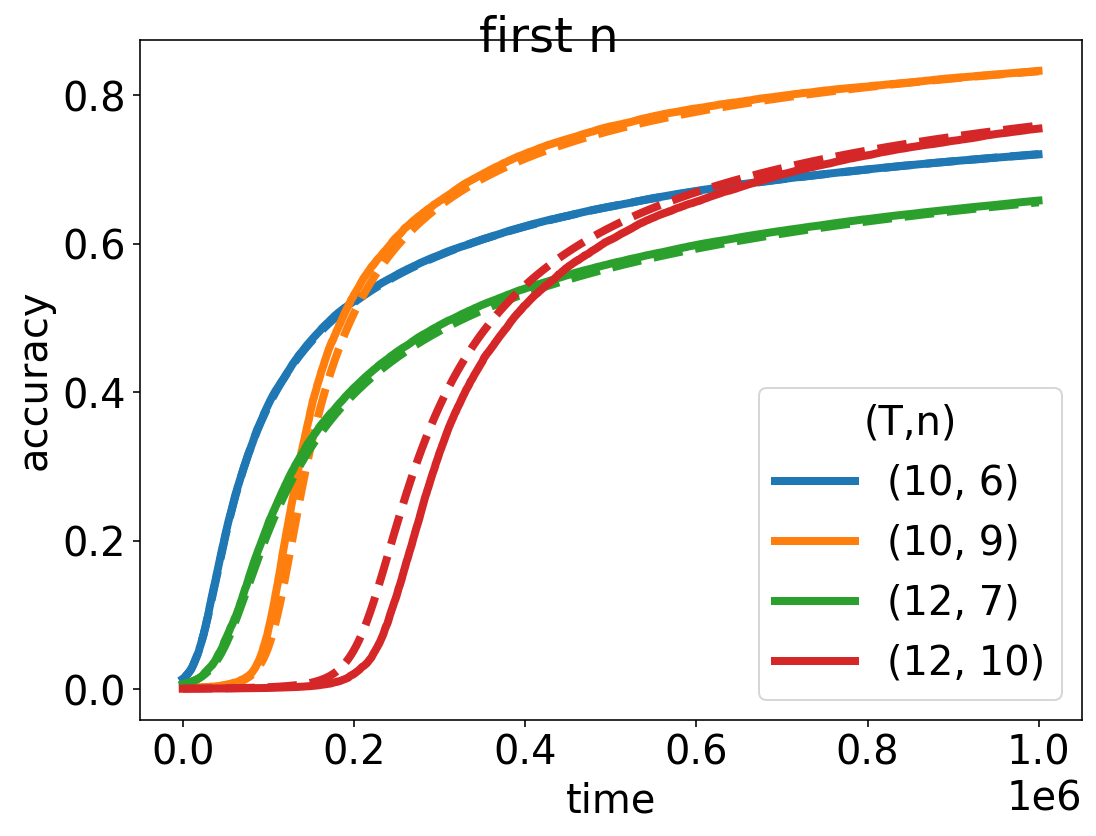

In [ ]:
fig, ax = plt.subplots(figsize=(4 /3 * fig_size, fig_size))
fig.suptitle("first n")
algo_idx = 0
for algo in Ts_2:
    for n in ns_2[algo]:
      color = "C" + str(algo_idx)
      ax.plot(steps_rl_sim, accuracies_rl_sim_2[(algo,n)], label=(algo,n), color=color)
      ax.plot(steps_rl_ode , accuracies_rl_ode_2[(algo,n)], "--", color=color)
      algo_idx += 1
ax.legend(title='(T,n)')
ax.set_xlabel("time")
ax.set_ylabel("accuracy")
# ax.set_ylim(top=1)
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(steps_rl_ode, accuracies_rl_ode_2[(3,2)])
plt.plot(steps_rl_sim,accuracies_rl_sim_2[(3,2)])
plt.xlabel('time')
plt.ylabel('accuracy')
plt.title('T=3, n = 2')

SyntaxError: ignored

In [ ]:
w_teacher = rnd.randn(50)
w_teacher /= np.sqrt(w_teacher @ w_teacher / 50)
w_student = w_teacher + rnd.randn(50)/2500
size = (np.linalg.norm(w_teacher))
unit = w_teacher/size

xs = rnd.randn(700000,50)
ys = np.sign(w_teacher @ xs.T)
ypred = np.sign(w_student @ xs.T)

Y = ys*ypred
Y += 1
Y /= 2
N = np.sum(Y)

alt_x = Y[:, None] * xs
mags = np.linalg.norm(xs, axis = 1)**2
print(np.sum(mags)/N)

50.0165413306455


In [6]:
"""
Experimentation with update rule: only update if any n in a row correct
"""
"""Ts = [3, 10]
ns = {3:[2,3], 10:[6,8,10]}"""

Ts_2 = [10]
ns = {10:[6]}

# student weight vectors
std0 = 1  # std dev of the initial student weights.

w_rl_student_2 = dict()
w_student_2 = rnd.randn(D)
for T in Ts_2:
    for n in ns[T]:
      w_rl_student_2[(T,n)] = w_student_2
    
# learning rates
lr = 1

# make a copy of the initial conditions of the students for 
# later comparisons with the ODE integration
w_rl_init_2 = copy.deepcopy(w_rl_student_2)

step = 0
num_steps = 5000 * D

steps_rl_sim = []
accuracies_rl_sim_2 = dict()
for T in Ts_2:
    for n in ns[T]:
      accuracies_rl_sim_2[(T,n)] = []
R_rl_sim_2 = copy.deepcopy(accuracies_rl_sim_2)
Q_rl_sim_2 = copy.deepcopy(accuracies_rl_sim_2)

while step < num_steps:
    for T in Ts_2:
        for n in ns[T]:
            # sample new input, output pair
            xs = rnd.randn(T, D)
            ys = np.sign(w_teacher @ xs.T)

            ypred = ((np.sign(w_rl_student_2[(T,n)] @ xs.T) * ys) + 1)/2

            count = 0
            max_row = 0
            for i in ypred:
              if i == 1:
                count += 1
              else:
                max_row = max(max_row,count)
                count = 0
          
            reward = int(max_row >= n) #this is the only differing line of code

            hebbian_update = np.mean(ys[:, None] * xs, axis=0)

            w_rl_student_2[(T,n)] += lr / np.sqrt(D) * reward * hebbian_update
    
    if step % D == 0:
        steps_rl_sim += [step]
        for T in Ts_2:
          for n in ns[T]:
            p = test_accuracy(w_rl_student_2[(T,n)], w_teacher, 1)
            summand = p**T + 2 * p**(T-1) * (1-p)

            for i in range(n,T-1):
              summand += (T-1-i)*p**i * (1-p)**2 + 2*p**i * (1-p)

            accuracies_rl_sim_2[(T,n)] += [summand]
            R_rl_sim_2[(T,n)] += [w_teacher @ w_rl_student_2[(T,n)] / D]
            Q_rl_sim_2[(T,n)] += [w_rl_student_2[(T,n)] @ w_rl_student_2[(T,n)] / D]
            
    step += 1

In [13]:
"""
ODEs for update rule: update only if any n in a row correct
"""
Q_3 = dict()
R_3 = dict()
w_3 = copy.deepcopy(w_rl_init_2)

# Initial conditions for the order parameters
for T in Ts_2:
  for n in ns[T]:
    Q_3[(T,n)] = w_rl_init_2[(T,n)] @ w_rl_init_2[(T,n)] / D
    R_3[(T,n)] = w_rl_init_2[(T,n)] @ w_teacher / D
    
# Integrate equations of motion
step = 0
steps_rl_ode = []
accuracies_rl_ode_3 = dict()
accuracies_w_update_3 = dict()
for T in Ts_2:
  for n in ns[T]:
    accuracies_rl_ode_3[(T,n)] = []
    accuracies_w_update_3[(T,n)] = []
R_rl_ode_3 = copy.deepcopy(accuracies_rl_ode_3)    
Q_rl_ode_3 = copy.deepcopy(accuracies_rl_ode_3)
R_rl_3 = copy.deepcopy(accuracies_rl_ode_3)
Q_rl_3 = copy.deepcopy(accuracies_rl_ode_3)

dt = 1 / D

while step < num_steps:
    for T in Ts_2:
      for n in ns[T]:

        # compute the probability that one, all-but-one, or all predictions were correct
        normalised_overlap = R_3[(T,n)]/W * np.sqrt(D/Q_3[(T,n)])
        theta =  np.arccos(normalised_overlap)
        p_incorrect = 1 / np.pi * theta
        p_correct = 1-p_incorrect

        #unit_student_2 = w_3[(T,n)]/np.linalg.norm(w_3[(T,n)])
        #phi_2 = (np.pi - np.arccos(unit_student_2 @ unit_teacher))/2
        phi_1 = (np.pi - theta)/2

        C_2 = np.sqrt(np.pi*2)*np.sin(theta/2)/theta

        C_1 = np.sqrt(np.pi/2)*np.sin(phi_1)/phi_1
        #C_2 = np.sqrt(np.pi/2)*np.sin(phi_2)/phi_2
        
        half_overlap = np.sqrt(1 + normalised_overlap)
        half_incorrect = np.sqrt(1 - normalised_overlap)

        [a,b,c] = [0,0,0]
        for i in range(n,T-1):
          a += i * p_correct**i * ((T-i-1)*p_incorrect + 2)
          b += p_correct**i * ((T-i-1)*p_incorrect + 1)
          c += p_correct**i * (T-i-1) * ((T-i-2)*p_incorrect + 2)
        
        b += p_correct**(T-1)

        dR = ((a*p_incorrect + ((T-2)*p_incorrect + T)*p_correct**(T-1))*C_1*W/np.sqrt(2)*half_overlap
        - b*2*C_2*p_incorrect*W/np.sqrt(2)*half_incorrect
        + c*p_incorrect*np.sqrt(2/np.pi) * W * normalised_overlap) * lr /(T*np.sqrt(D))
        
        [u,v,w,x,y,z] = [0,0,0,0,0,0]
        for i in range(n,T-1):
          u += p_correct**i * (2 + p_incorrect*(T-i-1))
          v += p_correct**i * i * (i-1) * (2 + p_incorrect*(T-i-1))
          w += p_correct**i * (T-i-1)
          x += p_correct**i * (T-i-1) * (T-i-2) * (2 + p_incorrect*(T-i-3))
          y += p_correct**i * i * (T-i-1) * (2 + p_incorrect*(T-i-2))
          z += p_correct**i * (T-i-1) * (1 + p_incorrect*(T-i-2))

        dQ = (2*lr/(T*np.sqrt(D)) * ((a*p_incorrect + ((T-2)*p_incorrect + T)*p_correct**(T-1))*C_1*np.sqrt(D*Q_3[(T,n)]/2)*half_overlap
        + b*2*C_2*p_incorrect*np.sqrt(D*Q_3[(T,n)]/2)*half_incorrect
        + c*p_incorrect*np.sqrt(2*D*Q_3[(T,n)]/np.pi)) + ((u*p_incorrect + p_correct**(T-1)*(1 + p_incorrect))*T*D + (v*p_incorrect + (T-1)*p_correct**(T-1)*(T + (T-4)*p_incorrect))*C_1**2 
        + 2*w*p_incorrect**2 * C_2**2 + x*p_incorrect*2/np.pi + 2*p_incorrect*y*half_overlap * C_1 / np.sqrt(np.pi) + 4*p_incorrect*z*half_incorrect*C_2/np.sqrt(np.pi))*lr**2/(D*T**2))
        
        R_3[(T,n)] += dt * dR
        Q_3[(T,n)] += dt * dQ
        #w_2[(T,n)] += dt * dw
        
    if step % D == 0:
      steps_rl_ode += [step]
      for T in Ts_2:
        for n in ns[T]:
          p_incorrect = 1 / np.pi * np.arccos(R_3[(T,n)] / W *np.sqrt(D/Q_3[(T,n)]))
          p_correct = 1-p_incorrect
          
          summand = p_correct**T + 2 * p_correct**(T-1) * p_incorrect

          for i in range(n,T-1):
            summand += (T-1-i)*p_correct**i * p_incorrect**2 + 2*p_correct**i * p_incorrect

          accuracies_rl_ode_3[(T,n)].append(summand)
          #accuracies_w_update_2[(T,n)] += [test_accuracy(w_2[(T,n)], w_teacher, n)]
          #R_rl_2[(T,n)] += [w_teacher @ w_2[(T,n)] / D]
          #Q_rl_2[(T,n)] += [w_2[(T,n)] @ w_2[(T,n)] / D]
          R_rl_ode_3[(T,n)].append(R_3[(T,n)])
          Q_rl_ode_3[(T,n)].append(Q_3[(T,n)])

    step += 1

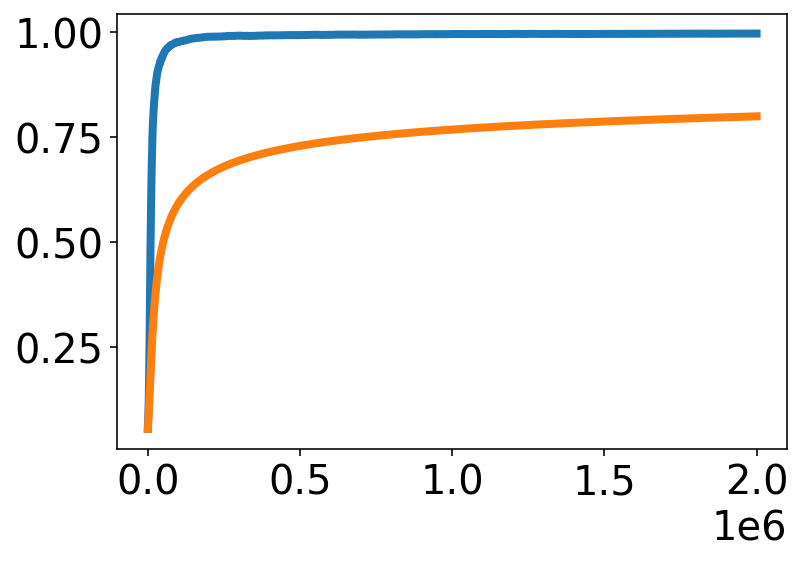

In [15]:
plt.plot(steps_rl_sim,  accuracies_rl_sim_2[(10,6)])
plt.plot(steps_rl_ode, accuracies_rl_ode_3[(10,6)])

In [11]:
while True:
  pass

KeyboardInterrupt: ignored

In [ ]:
"""
Experimentation with update rule: only update if n or more correct
"""
"""Ts = [3, 10]
ns = {3:[2,3], 10:[6,8,10]}"""

"""Ts_3 = [3,6,10,12]
ns = {3:[2], 6:[4],10:[6,9],12:[7,10]}"""

Ts_3 = [10,12]
ns_3 = {10:[6,9],12:[7,10]}

# student weight vectors
std0 = 1  # std dev of the initial student weights.

w_rl_student_3 = dict()
w_student_3 = rnd.randn(D)
for T in Ts_3:
    for n in ns_3[T]:
      w_rl_student_3[(T,n)] = w_student_3.copy()
    
# learning rates
lr = 1

# make a copy of the initial conditions of the students for 
# later comparisons with the ODE integration
w_rl_init_3 = copy.deepcopy(w_rl_student_3)

step = 0
num_steps = 2500 * D

steps_rl_sim = []
accuracies_rl_sim_3 = dict()
for T in Ts_3:
    for n in ns_3[T]:
      accuracies_rl_sim_3[(T,n)] = []
R_rl_sim_3 = copy.deepcopy(accuracies_rl_sim_3)
Q_rl_sim_3 = copy.deepcopy(accuracies_rl_sim_3)

while step < num_steps:
    for T in Ts_3:
        for n in ns_3[T]:
            # sample new input, output pair
            xs = rnd.randn(T, D)
            ys = np.sign(w_teacher @ xs.T)

            ypred = np.sign(w_rl_student_3[(T,n)] @ xs.T)

            test = ypred*ys +1
            reward = int(sum(test) >= 2*n) #this is the only differing line of code

            hebbian_update = np.mean(ypred[:, None] * xs, axis=0)

            w_rl_student_3[(T,n)] += lr / np.sqrt(D) * reward * hebbian_update
    
    if step % D == 0:
      steps_rl_sim += [step]
      for T in Ts_3:
        for n in ns_3[T]:
          correct = 0
          p = test_accuracy(w_rl_student_3[(T,n)], w_teacher, 1)
          for i in range(n,T+1):
            correct += scipy.special.binom(T,i) * p**i * (1-p)**(T-i)

          accuracies_rl_sim_3[(T,n)] += [correct]
          R_rl_sim_3[(T,n)] += [w_teacher @ w_rl_student_3[(T,n)] / D]
          Q_rl_sim_3[(T,n)] += [w_rl_student_3[(T,n)] @ w_rl_student_3[(T,n)] / D]
            
    step += 1

In [ ]:
"""
ODEs for update rule: update if n or more correct
"""
Q_3 = dict()
R_3 = dict()
w_3 = copy.deepcopy(w_rl_init_3)

# Initial conditions for the order parameters
for T in Ts_3:
  for n in ns_3[T]:
    Q_3[(T,n)] = w_rl_init_3[(T,n)] @ w_rl_init_3[(T,n)] / D
    R_3[(T,n)] = w_rl_init_3[(T,n)] @ w_teacher / D
    
# Integrate equations of motion
step = 0
steps_rl_ode = []
accuracies_rl_ode_3 = dict()
accuracies_w_update_3 = dict()
for T in Ts_3:
  for n in ns_3[T]:
    accuracies_rl_ode_3[(T,n)] = []
    accuracies_w_update_3[(T,n)] = []
R_rl_ode_3 = copy.deepcopy(accuracies_rl_ode_3)    
Q_rl_ode_3 = copy.deepcopy(accuracies_rl_ode_3)
R_rl_3 = copy.deepcopy(accuracies_rl_ode_3)
Q_rl_3 = copy.deepcopy(accuracies_rl_ode_3)

dt = 1 / D

while step < num_steps:
    for T in Ts_3:
      for n in ns_3[T]:
        # compute the probability that one, all-but-one, or all predictions were correct
        normalised_overlap = R_3[(T,n)]/W * np.sqrt(D/Q_3[(T,n)])
        p_correct = (1 - 1 / np.pi * np.arccos(normalised_overlap))
        
        #unit_student_2 = w_2[(T,n)]/np.linalg.norm(w_2[(T,n)])
        #phi_2 = (np.pi - np.arccos(unit_student_2 @ unit_teacher))/2
        phi_1 = (np.pi - np.arccos(normalised_overlap))/2

        theta = np.arccos(normalised_overlap)/2
        C_2 = np.sqrt(np.pi/2)*np.sin(theta)/theta

        C_1 = np.sqrt(np.pi/2)*np.sin(phi_1)/phi_1
        #C_2 = np.sqrt(np.pi/2)*np.sin(phi_2)/phi_2
        
        half_overlap = np.sqrt(1 + normalised_overlap)
        half_incorrect = np.sqrt(1 - normalised_overlap)

        a = 0
        b = 0

        c = 0
        d = 0
        e = 0

        for i in range(n,T+1):
          p_i = p_correct**i
          q_i = (1-p_correct)**(T-i)
          a += scipy.special.binom(T,i) * i * p_i * q_i
          b += scipy.special.binom(T,i) *(T-i) * p_i * q_i

          c += scipy.special.binom(T,i)  * p_i * q_i
          d += scipy.special.binom(T,i) * i* (i-1) * p_i * q_i
          e += scipy.special.binom(T,i) * (T-i)* (T-i-1) * p_i * q_i


        dR = lr/(T*np.sqrt(D)) * (a*C_1*W/np.sqrt(2) * half_overlap - b*C_2*W/np.sqrt(2)*half_incorrect) 
        
        dQ = (2 * lr/(T*np.sqrt(D)) * (a*C_1*np.sqrt(D*Q_3[(T,n)]/2) * half_overlap + b*C_2*np.sqrt(D*Q_3[(T,n)]/2)*half_incorrect) + 
              lr**2/(T**2 *D) * (c*T*D + d*C_1**2 + e* C_2**2))

        #dw = lr*np.sqrt(D)/T * test_accuracy(w_2[(T,n)], w_teacher, n) * (n*C_2*(unit_teacher + unit_student_2)/np.linalg.norm(unit_teacher + unit_student_2) + (T-n)*np.sqrt(np.pi/2)*unit_student_2)
        
        R_3[(T,n)] += dt * dR
        Q_3[(T,n)] += dt * dQ
        #w_2[(T,n)] += dt * dw
        
    #if step % D == 0:
    steps_rl_ode += [step]
    for T in Ts_3:
      for n in ns_3[T]:
        correct = 0
        p = test_accuracy_op(Q_3[(T,n)], R_3[(T,n)], 1)
        for i in range(n,T+1):
          correct += scipy.special.binom(T,i) * p**i * (1-p)**(T-i)

        accuracies_rl_ode_3[(T,n)].append(correct)
        #accuracies_w_update_2[(T,n)] += [test_accuracy(w_2[(T,n)], w_teacher, n)]
        #R_rl_2[(T,n)] += [w_teacher @ w_2[(T,n)] / D]
        #Q_rl_2[(T,n)] += [w_2[(T,n)] @ w_2[(T,n)] / D]
        R_rl_ode_3[(T,n)].append(R_3[(T,n)])
        Q_rl_ode_3[(T,n)].append(Q_3[(T,n)])

    step += 1


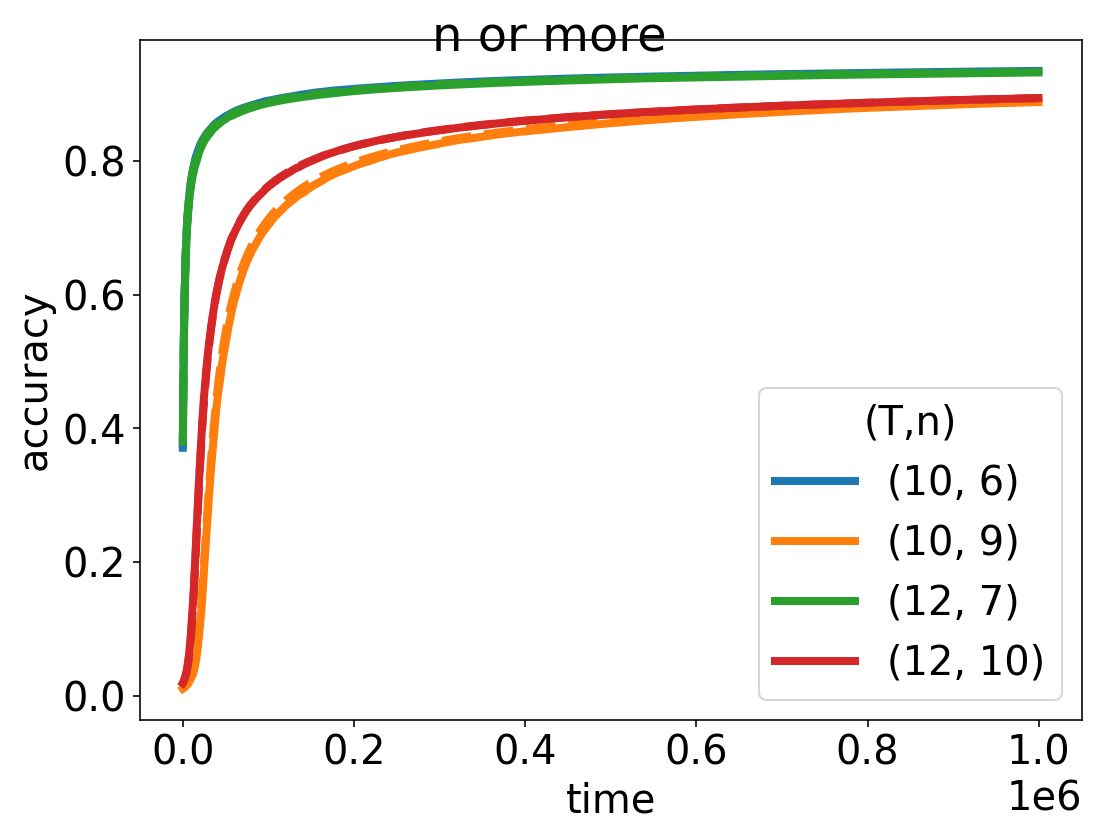

In [ ]:
fig, ax = plt.subplots(figsize=(4 /3 * fig_size, fig_size))
fig.suptitle("n or more")
algo_idx = 0
for algo in Ts_3:
    for n in ns_3[algo]:
      color = "C" + str(algo_idx)
      ax.plot(steps_rl_sim, accuracies_rl_sim_3[(algo,n)], label=(algo,n), color=color)
      ax.plot(steps_rl_ode , accuracies_rl_ode_3[(algo,n)], "--", color=color)
      algo_idx += 1
ax.legend(title='(T,n)')
ax.set_xlabel("time")
ax.set_ylabel("accuracy")
# ax.set_ylim(top=1)
plt.tight_layout()
plt.show()

In [16]:
"""
Experimentation: +ve reward if all correct, -ve otherwise
"""

Ts = [10]
etas = [0.001, 0.002,0.003,0.004]
# student weight vectors
std0 = 1  # std dev of the initial student weights.

w_rl_student = dict()
w_student = rnd.randn(D)
for T in Ts:
  for eta in etas:
    w_rl_student[(T,eta)] = w_student.copy()
    
# learning rates
lr_1 = 1
lr_2s = dict()
for eta in etas:
  lr_2s[eta] = eta*lr_1

# make a copy of the initial conditions of the students for 
# later comparisons with the ODE integration
w_rl_init = copy.deepcopy(w_rl_student)

step = 0
num_steps = 1250 * D

steps_rl_sim = []
accuracies_rl_sim_neg = dict()
for T in Ts:
  for eta in etas:
    accuracies_rl_sim_neg[(T,eta)] = []
R_rl_sim_neg = copy.deepcopy(accuracies_rl_sim_neg)
Q_rl_sim_neg = copy.deepcopy(accuracies_rl_sim_neg)

while step < num_steps:
    for T in Ts:
      for eta in etas:
        lr_2 = lr_2s[eta]
        # sample new input, output pair
        xs = rnd.randn(T, D)
        ys = np.sign(w_teacher @ xs.T)

        ypred = np.sign(w_rl_student[(T,eta)] @ xs.T)

        reward_1 = lr_1 * np.all(ys == ypred)
        reward_2 = lr_2 * (np.all(ys == ypred) -1)
        reward = reward_1 + reward_2

        hebbian_update = np.mean(ys[:, None] * xs, axis=0)

        w_rl_student[(T,eta)] += 1/ np.sqrt(D) * reward * hebbian_update
    
    if step % D == 0:
      steps_rl_sim += [step]
      for T in Ts:
        for eta in etas:
          accuracies_rl_sim_neg[(T,eta)] += [test_accuracy(w_rl_student[(T,eta)], w_teacher, T)]
          R_rl_sim_neg[(T,eta)] += [w_teacher @ w_rl_student[(T,eta)] / D]
          Q_rl_sim_neg[(T,eta)] += [w_rl_student[(T,eta)] @ w_rl_student[(T,eta)] / D]
            
    step += 1

In [17]:
"""
ODEs:  +ve reward if all correct, -ve otherwise
"""
Q_neg = dict()
R_neg = dict()
Q_neg_f = dict()
R_neg_f = dict()
w = copy.deepcopy(w_rl_init)

# Initial conditions for the order parameters
for T in Ts:
  for eta in etas:
    Q_neg[(T,eta)] = w_rl_init[(T,eta)] @ w_rl_init[(T,eta)] / D
    R_neg[(T,eta)] = w_rl_init[(T,eta)] @ w_teacher / D
    Q_neg_f[(T,eta)] = w_rl_init[(T,eta)] @ w_rl_init[(T,eta)] / D
    R_neg_f[(T,eta)] = w_rl_init[(T,eta)] @ w_teacher / D
    
# Integrate equations of motion
step = 0
steps_rl_ode = []
accuracies_rl_ode_neg = dict()
accuracies_rl_ode_neg_f = dict()
accuracies_w_update = dict()
for T in Ts:
  for eta in etas:
    accuracies_rl_ode_neg[(T,eta)] = []
    accuracies_rl_ode_neg_f[(T,eta)] = []
    accuracies_w_update[(T,eta)] = []
R_rl_ode_neg = copy.deepcopy(accuracies_rl_ode_neg)    
Q_rl_ode_neg = copy.deepcopy(accuracies_rl_ode_neg)
R_rl_ode_neg_f = copy.deepcopy(accuracies_rl_ode_neg)    
Q_rl_ode_neg_f = copy.deepcopy(accuracies_rl_ode_neg)

dt = 1 / D

while step < num_steps:
    for T in Ts:
      for eta in etas:
        lr_2 = lr_2s[eta]
        # compute the probability that one, all-but-one, or all predictions were correct
        p_correct = (1 - 1 / np.pi * np.arccos(R_neg[(T,eta)] / W *np.sqrt(D/Q_neg[(T,eta)])))
        p_correct_all = p_correct**T
        unit_student = w[(T,eta)]/np.linalg.norm(w[(T,eta)])
        phi_2 = (np.pi - np.arccos(unit_student@unit_teacher))/2
        phi_1 = (np.pi - np.arccos(R_neg[(T,eta)] / W *np.sqrt(D/Q_neg[(T,eta)])))/2

        C_1 = np.sqrt(np.pi/2)*np.sin(phi_1)/phi_1
        C_2 = np.sqrt(np.pi/2)*np.sin(phi_2)/phi_2
        
        half_overlap = np.sqrt(1 + R_neg[(T,eta)]/W * np.sqrt(D/Q_neg[(T,eta)]))

        dR = (lr_1 + lr_2) * W*C_1/np.sqrt(2*D) * p_correct_all * half_overlap - lr_2 * R_neg[(T,eta)] * np.sqrt(2/(Q_neg[(T,eta)]*np.pi))
        
        dQ = lr_2**2/(T*D) *(D + (T-1)*2/np.pi) - 2*lr_2*np.sqrt(2*Q_neg[(T,eta)]/np.pi) + ((lr_1**2 - lr_2**2)*(D+ (T-1)*C_1**2)/(T*D) + (lr_1 + lr_2)*np.sqrt(2*Q_neg[(T,eta)])*half_overlap*C_1)*p_correct_all
        
        dw = (lr_1 + lr_2) * np.sqrt(D)*C_2*test_accuracy(w[(T,eta)], w_teacher, T) * (unit_teacher + unit_student)/np.linalg.norm(unit_teacher + unit_student) - lr_2*np.sqrt(2*D/np.pi)*unit_student
        
        
        R_neg[(T,eta)] += dt * dR
        Q_neg[(T,eta)] += dt * dQ
        w[(T,eta)] += dt * dw

        p_f = (1 - 1 / np.pi * np.arccos(R_neg_f[(T,eta)] / np.sqrt(Q_neg_f[(T,eta)])))
        p_f_all = p_f**T
        p_f_others = p_f**(T-1)


        dR_neg_f = (lr_1 + lr_2) / np.sqrt(2 * np.pi) * (1 + R_neg_f[(T,eta)] / np.sqrt(Q_neg_f[(T,eta)])) * p_f_others - lr_2 * R_neg_f[(T,eta)] * np.sqrt(2/(Q_neg_f[(T,eta)]*np.pi))
        dQ_neg_f = ((lr_1 + lr_2) * np.sqrt(2 / np.pi) * (np.sqrt(Q_neg_f[(T,eta)]) + R_neg_f[(T,eta)]) * p_f_others - 2*lr_2*np.sqrt(2*Q_neg_f[(T,eta)]/np.pi) 
                + (lr_1**2 - lr_2**2) / (T*D) * (D*p_f**2 + (T-1)/np.pi*(1 + R_neg_f[(T,eta)] / np.sqrt(Q_neg_f[(T,eta)])))*p_f**(T-2) + lr_2**2/(T*D) *(D + (T-1)*2/np.pi))
        
      
        R_neg_f[(T,eta)] += dt * dR_neg_f
        Q_neg_f[(T,eta)] += dt * dQ_neg_f

        
    if step % D == 0:
      steps_rl_ode += [step]
      for T in Ts:
        for eta in etas:
          accuracies_rl_ode_neg[(T,eta)] += [test_accuracy_op(Q_neg[(T,eta)], R_neg[(T,eta)], T)]
          accuracies_rl_ode_neg_f[(T,eta)] += [test_accuracy_op(Q_neg_f[(T,eta)], R_neg_f[(T,eta)], T)]
          accuracies_w_update[(T,eta)] += [test_accuracy(w[(T,eta)], w_teacher, T)]
          R_rl_ode_neg[(T,eta)] += [R_neg[(T,eta)]]
          Q_rl_ode_neg[(T,eta)] += [Q_neg[(T,eta)]]
          R_rl_ode_neg_f[(T,eta)] += [R_neg_f[(T,eta)]]
          Q_rl_ode_neg_f[(T,eta)] += [Q_neg_f[(T,eta)]]
    step += 1


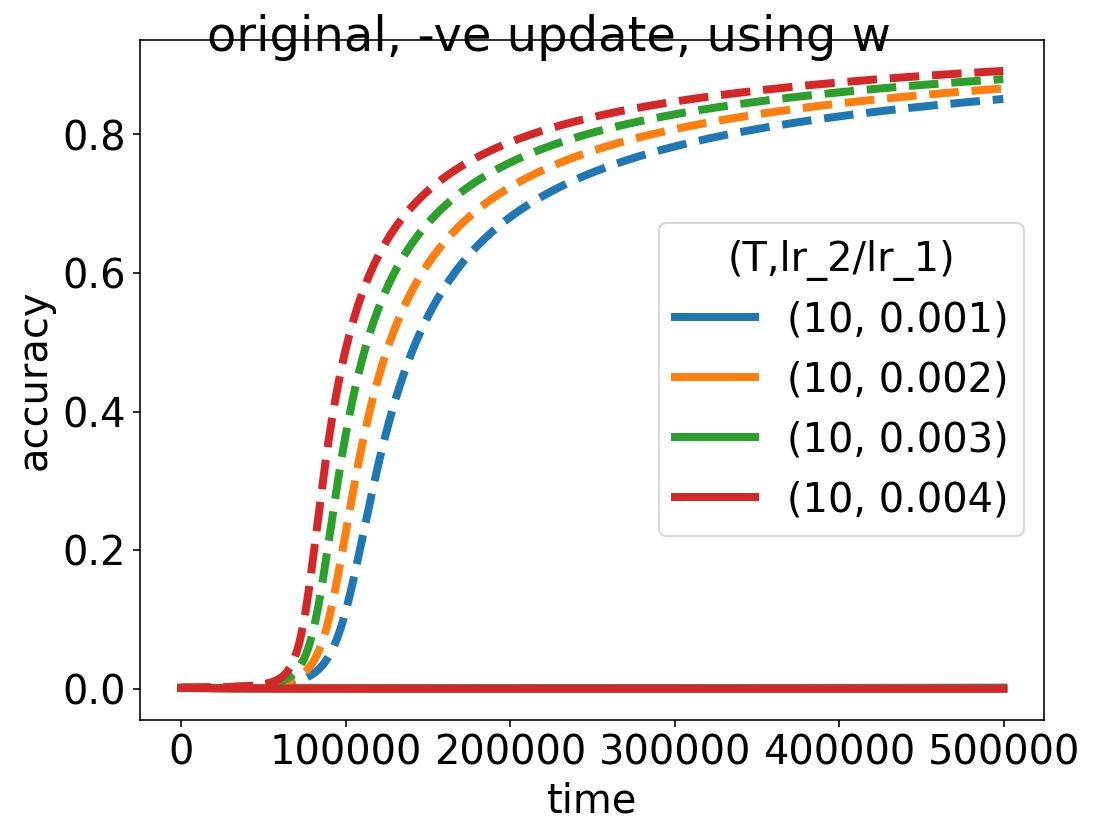

In [18]:
fig, ax = plt.subplots(figsize=(4 /3 * fig_size, fig_size))
fig.suptitle(f"original, -ve update, using w")
algo_idx = 0
for algo in Ts:
    for eta in etas:
      color = "C" + str(algo_idx)
      ax.plot(steps_rl_sim, accuracies_rl_sim_neg[(algo,eta)], label=(algo,eta), color=color)
      ax.plot(steps_rl_ode, accuracies_w_update[(algo,eta)], "--", color=color)
      algo_idx += 1
ax.legend(title='(T,lr_2/lr_1)')
ax.set_xlabel("time")
ax.set_ylabel("accuracy")
# ax.set_ylim(top=1)
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(steps_rl_sim,accuracies_rl_sim_neg[(10,0.005)])

In [ ]:
plt.plot(steps_rl_sim,R_rl_sim_neg[(10,0.005)])

In [ ]:
plt.plot(steps_rl_sim,Q_rl_sim_neg[(10,0.005)])

ValueError: ignored

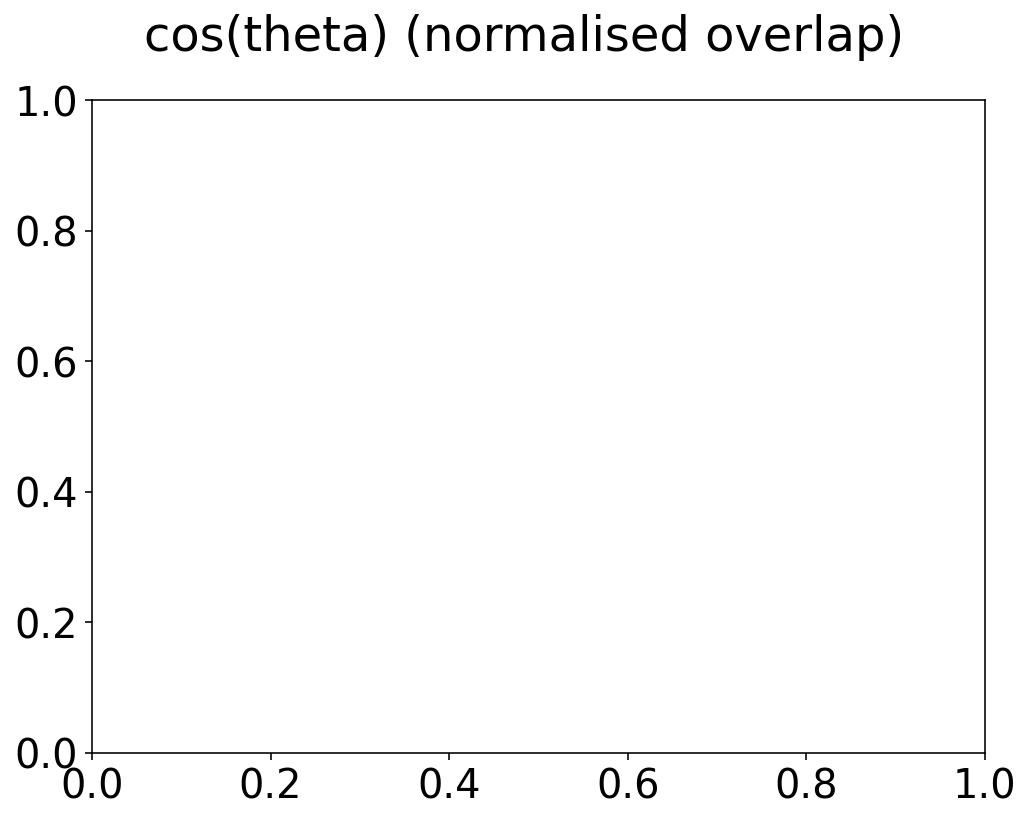

In [31]:
fig, ax = plt.subplots(figsize=(4 /3 * fig_size, fig_size))
fig.suptitle(f"cos(theta) (normalised overlap)")
algo_idx = 0
for algo in Ts:
    for eta in etas:
      color = "C" + str(algo_idx)
      r = np.array(R_rl_sim_neg[(algo,eta)])
      q = np.sqrt(np.array(Q_rl_sim_neg[(algo,eta)]))
      overlap = np.divide(r,q)
      ax.plot(steps_rl_sim, overlap, label=(algo,eta), color=color)
      algo_idx += 1
ax.legend(title='(T,lr_2/lr_1)')
ax.set_xlabel("time")
ax.set_ylabel("accuracy")
# ax.set_ylim(top=1)
plt.tight_layout()
plt.show()


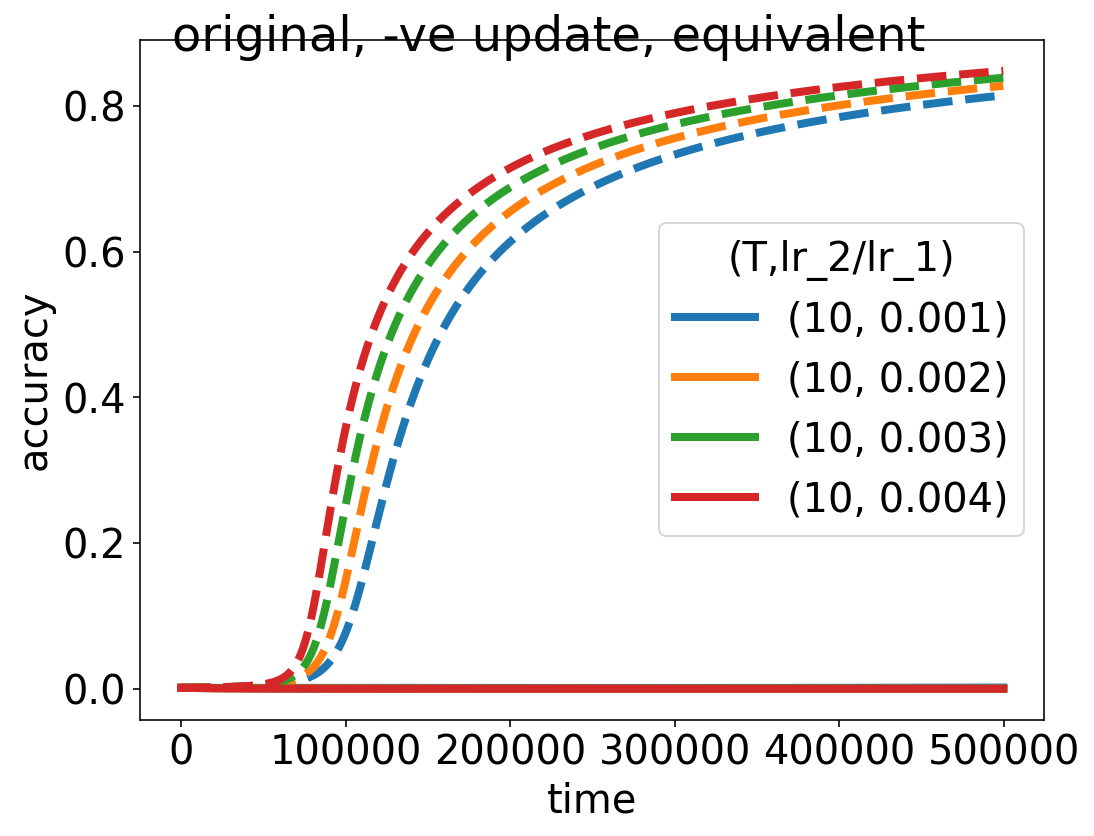

In [20]:
fig, ax = plt.subplots(figsize=(4 /3 * fig_size, fig_size))
fig.suptitle(f"original, -ve update, equivalent")
algo_idx = 0
for algo in Ts:
    for eta in etas:
      color = "C" + str(algo_idx)
      ax.plot(steps_rl_sim, accuracies_rl_sim_neg[(algo,eta)], label=(algo,eta), color=color)
      ax.plot(steps_rl_ode , accuracies_rl_ode_neg_f[(algo,eta)], "--", color=color)
      algo_idx += 1
ax.legend(title='(T,lr_2/lr_1)')
ax.set_xlabel("time")
ax.set_ylabel("accuracy")
# ax.set_ylim(top=1)
plt.tight_layout()
plt.show()

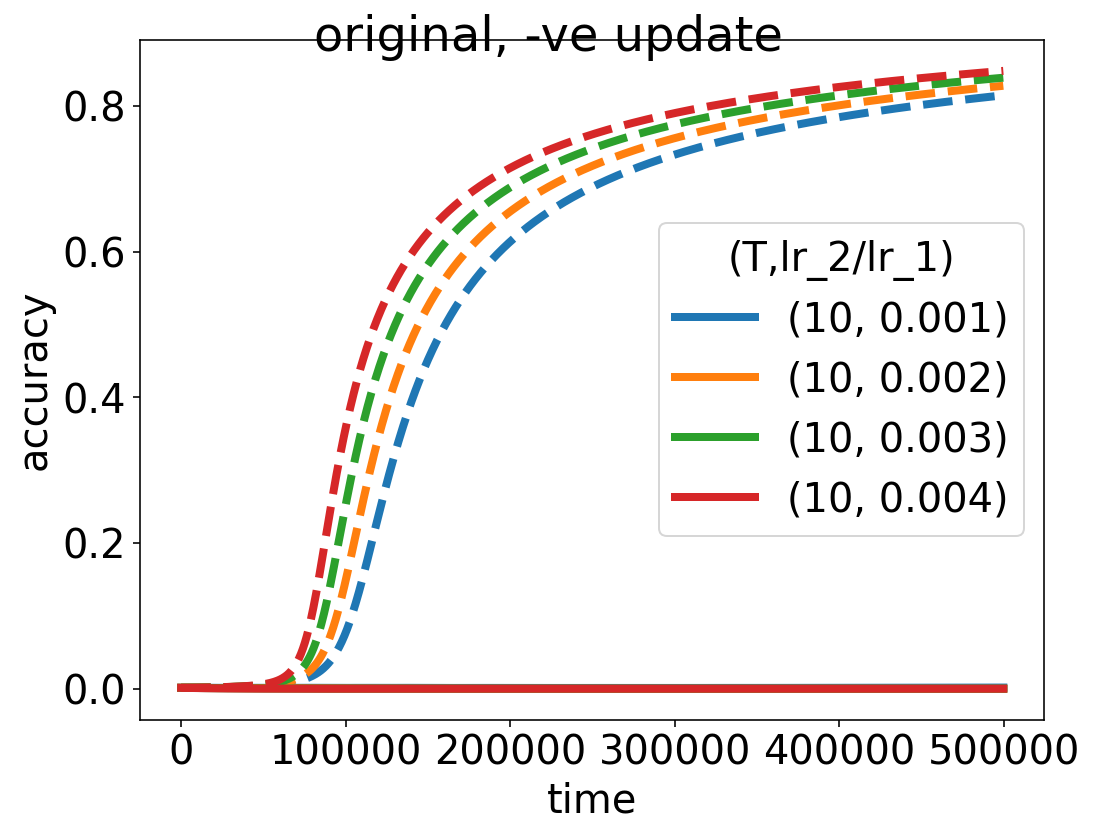

In [21]:
fig, ax = plt.subplots(figsize=(4 /3 * fig_size, fig_size))
fig.suptitle(f"original, -ve update")
algo_idx = 0
for algo in Ts:
    for eta in etas:
      color = "C" + str(algo_idx)
      ax.plot(steps_rl_sim, accuracies_rl_sim_neg[(algo,eta)], label=(algo,eta), color=color)
      ax.plot(steps_rl_ode , accuracies_rl_ode_neg[(algo,eta)], "--", color=color)
      algo_idx += 1
ax.legend(title='(T,lr_2/lr_1)')
ax.set_xlabel("time")
ax.set_ylabel("accuracy")
# ax.set_ylim(top=1)
plt.tight_layout()
plt.show()

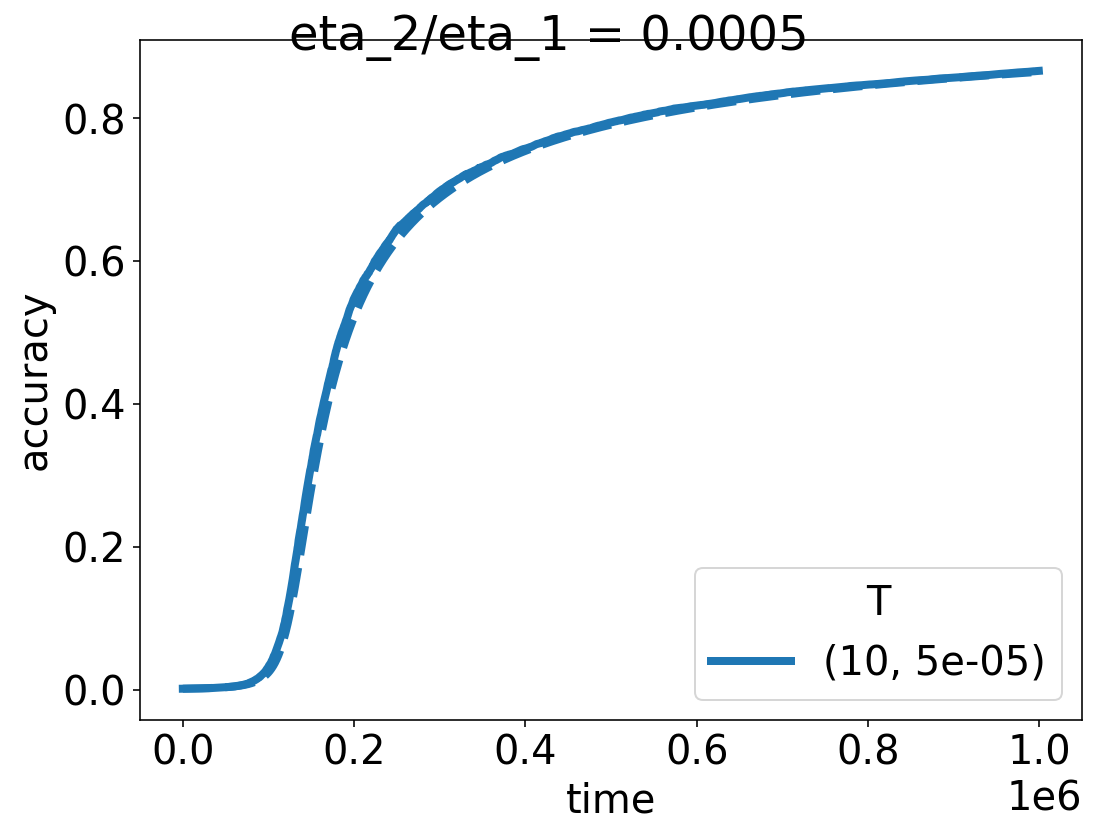

In [ ]:
fig, ax = plt.subplots(figsize=(4 /3 * fig_size, fig_size))
fig.suptitle("eta_2/eta_1 = 0.0005")
for algo_idx, algo in enumerate(w_rl_student.keys()):
    color = "C" + str(algo_idx)
    ax.plot(steps_rl_sim, accuracies_rl_sim_neg[algo], label=algo, color=color)
    ax.plot(steps_rl_ode , accuracies_rl_ode_neg[algo], "--", color=color)
ax.legend(title='T')
ax.set_xlabel("time")
ax.set_ylabel("accuracy")
# ax.set_ylim(top=1)
plt.tight_layout()
plt.show()

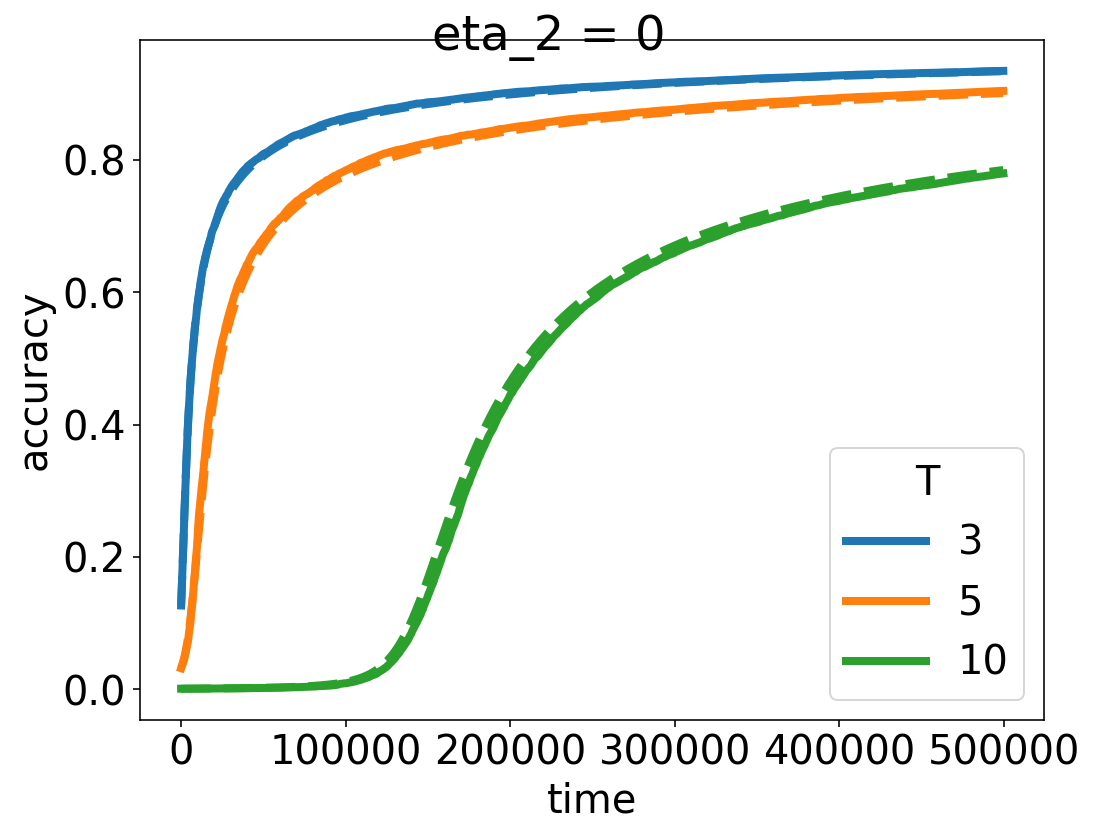

In [ ]:
fig, ax = plt.subplots(figsize=(4 /3 * fig_size, fig_size))
fig.suptitle("eta_2 = 0")
for algo_idx, algo in enumerate(w_rl_student.keys()):
    color = "C" + str(algo_idx)
    ax.plot(steps_rl_sim, accuracies_rl_sim_neg[algo], label=algo, color=color)
    ax.plot(steps_rl_ode , accuracies_rl_ode_neg[algo], "--", color=color)
ax.legend(title='T')
ax.set_xlabel("time")
ax.set_ylabel("accuracy")
# ax.set_ylim(top=1)
plt.tight_layout()
plt.show()

In [22]:
"""
Experimentation with update rule: =ve if first n correct, -ve otherwise
"""
"""Ts = [3, 10]
ns = {3:[2,3], 10:[6,8,10]}"""

"""Ts_2_neg = [3,6,10,12]
ns_2_neg = {3:[2], 6:[4],10:[6,9],12:[7,10]}"""

Ts_2_neg = [12]
ns_2_neg = {12:[10]}
etas_2 = [0.001, 0.01, 0.1]

# student weight vectors
std0 = 1  # std dev of the initial student weights.

w_rl_student_2_neg = dict()
w_student_2 = rnd.randn(D)
for T in Ts_2_neg:
    for n in ns_2_neg[T]:
      for eta in etas_2:
        w_rl_student_2_neg[(T,n,eta)] = w_student_2.copy()
    
# learning rates
lr_1 = 1

# make a copy of the initial conditions of the students for 
# later comparisons with the ODE integration
w_rl_init_2_neg = copy.deepcopy(w_rl_student_2_neg)

step = 0
num_steps = 2500 * D

steps_rl_sim = []
accuracies_rl_sim_2_neg = dict()
for T in Ts_2_neg:
    for n in ns_2_neg[T]:
      for eta in etas_2:
        accuracies_rl_sim_2_neg[(T,n,eta)] = []
R_rl_sim_2_neg = copy.deepcopy(accuracies_rl_sim_2_neg)
Q_rl_sim_2_neg = copy.deepcopy(accuracies_rl_sim_2_neg)

while step < num_steps:
    for T in Ts_2_neg:
        for n in ns_2_neg[T]:
          for eta in etas_2:
            lr_2 = eta
            # sample new input, output pair
            xs = rnd.randn(T, D)
            ys = np.sign(w_teacher @ xs.T)

            ypred = np.sign(w_rl_student_2_neg[(T,n,eta)] @ xs.T)

            reward = np.all(ys[:n] == ypred[:n]) #this is the only differing line of code

            hebbian_update = np.mean(ypred[:, None] * xs, axis=0)

            w_rl_student_2_neg[(T,n,eta)] += lr_1 / np.sqrt(D) * reward * hebbian_update - lr_2/np.sqrt(D) * hebbian_update * (1-reward)
    
    if step % D == 0:
      steps_rl_sim += [step]
      for T in Ts_2_neg:
        for n in ns_2_neg[T]:
          for eta in etas_2:
            accuracies_rl_sim_2_neg[(T,n,eta)] += [test_accuracy(w_rl_student_2_neg[(T,n,eta)], w_teacher, n)]
            R_rl_sim_2_neg[(T,n,eta)] += [w_teacher @ w_rl_student_2_neg[(T,n,eta)] / D]
            Q_rl_sim_2_neg[(T,n,eta)] += [w_rl_student_2_neg[(T,n,eta)] @ w_rl_student_2_neg[(T,n,eta)] / D]
            
    step += 1

In [23]:
"""
ODEs for update rule: +ve update if first n correct, -ve otherwise
"""
Q_2_neg = dict()
R_2_neg = dict()
w_2_neg = copy.deepcopy(w_rl_init_2_neg)

# Initial conditions for the order parameters
for T in Ts_2_neg:
  for n in ns_2_neg[T]:
    for eta in etas_2:
      Q_2_neg[(T,n,eta)] = w_rl_init_2_neg[(T,n,eta)] @ w_rl_init_2_neg[(T,n,eta)] / D
      R_2_neg[(T,n,eta)] = w_rl_init_2_neg[(T,n,eta)] @ w_teacher / D
      
# Integrate equations of motion
step = 0
steps_rl_ode = []
accuracies_rl_ode_2_neg = dict()
accuracies_w_update_2 = dict()
for T in Ts_2_neg:
  for n in ns_2_neg[T]:
    for eta in etas_2:
      accuracies_rl_ode_2_neg[(T,n,eta)] = []
    #accuracies_w_update_2[(T,n)] = []
R_rl_ode_2_neg = copy.deepcopy(accuracies_rl_ode_2_neg)    
Q_rl_ode_2_neg = copy.deepcopy(accuracies_rl_ode_2_neg)
R_rl_2_neg = copy.deepcopy(accuracies_rl_ode_2_neg)
Q_rl_2_neg = copy.deepcopy(accuracies_rl_ode_2_neg)

dt = 1 / D

while step < num_steps:
    for T in Ts_2_neg:
      for n in ns_2_neg[T]:
        for eta in etas_2:
          lr_2 = eta
          # compute the probability that one, all-but-one, or all predictions were correct
          normalised_overlap = R_2_neg[(T,n,eta)]/W * np.sqrt(D/Q_2_neg[(T,n,eta)])
          p_correct = (1 - 1 / np.pi * np.arccos(normalised_overlap))
          p_correct_n = p_correct**n
          #unit_student_2 = w_2[(T,n)]/np.linalg.norm(w_2[(T,n)])
          #phi_2 = (np.pi - np.arccos(unit_student_2 @ unit_teacher))/2
          phi_1 = (np.pi - np.arccos(normalised_overlap))/2

          theta = np.arccos(normalised_overlap)/2
          C = np.sqrt(np.pi/2)*np.sin(theta)/theta

          C_1 = np.sqrt(np.pi/2)*np.sin(phi_1)/phi_1
          #C_2 = np.sqrt(np.pi/2)*np.sin(phi_2)/phi_2
          
          half_overlap = np.sqrt(1 + normalised_overlap)
      

          dR = (lr_1 + lr_2)/(T*np.sqrt(D)) * p_correct_n * (n*C_1*W/np.sqrt(2)*half_overlap + (T-n)*np.sqrt(2/np.pi)*W*normalised_overlap) - lr_2*np.sqrt(2/(np.pi*D)) * W * normalised_overlap

          dQ = (2*(lr_1 + lr_2)/(T*np.sqrt(D))*(n*C_1*np.sqrt(D*Q_2_neg[(T,n,eta)]/2)*half_overlap + (T-n)*np.sqrt(2*D*Q_2_neg[(T,n,eta)]/np.pi)) + 
                (lr_1**2 - lr_2**2)/(D*T**2)*(T*D + 2*n*(T-n)/np.sqrt(np.pi)*C_1*half_overlap + 2/np.pi * (T-n)*(T-n-1) + n*(n-1)*C_1**2))*p_correct_n - 2*lr_2 * np.sqrt(2*Q_2_neg[(T,n,eta)]/np.pi) + lr_2**2/(T*D)*(D + (T-1)*2/np.pi)

          #dw = lr*np.sqrt(D)/T * test_accuracy(w_2[(T,n)], w_teacher, n) * (n*C_2*(unit_teacher + unit_student_2)/np.linalg.norm(unit_teacher + unit_student_2) + (T-n)*np.sqrt(np.pi/2)*unit_student_2)
          
          R_2_neg[(T,n,eta)] += dt * dR
          Q_2_neg[(T,n,eta)] += dt * dQ
          #w_2[(T,n)] += dt * dw
        
    if step % D == 0:
      steps_rl_ode += [step]
      for T in Ts_2_neg:
        for n in ns_2_neg[T]:
          for eta in etas_2:
            accuracies_rl_ode_2_neg[(T,n,eta)].append(test_accuracy_op(Q_2_neg[(T,n,eta)], R_2_neg[(T,n,eta)], n))
            #accuracies_w_update_2[(T,n)] += [test_accuracy(w_2[(T,n)], w_teacher, n)]
            #R_rl_2[(T,n)] += [w_teacher @ w_2[(T,n)] / D]
            #Q_rl_2[(T,n)] += [w_2[(T,n)] @ w_2[(T,n)] / D]
            R_rl_ode_2_neg[(T,n,eta)].append(R_2_neg[(T,n,eta)])
            Q_rl_ode_2_neg[(T,n,eta)].append(Q_2_neg[(T,n,eta)])

    step += 1

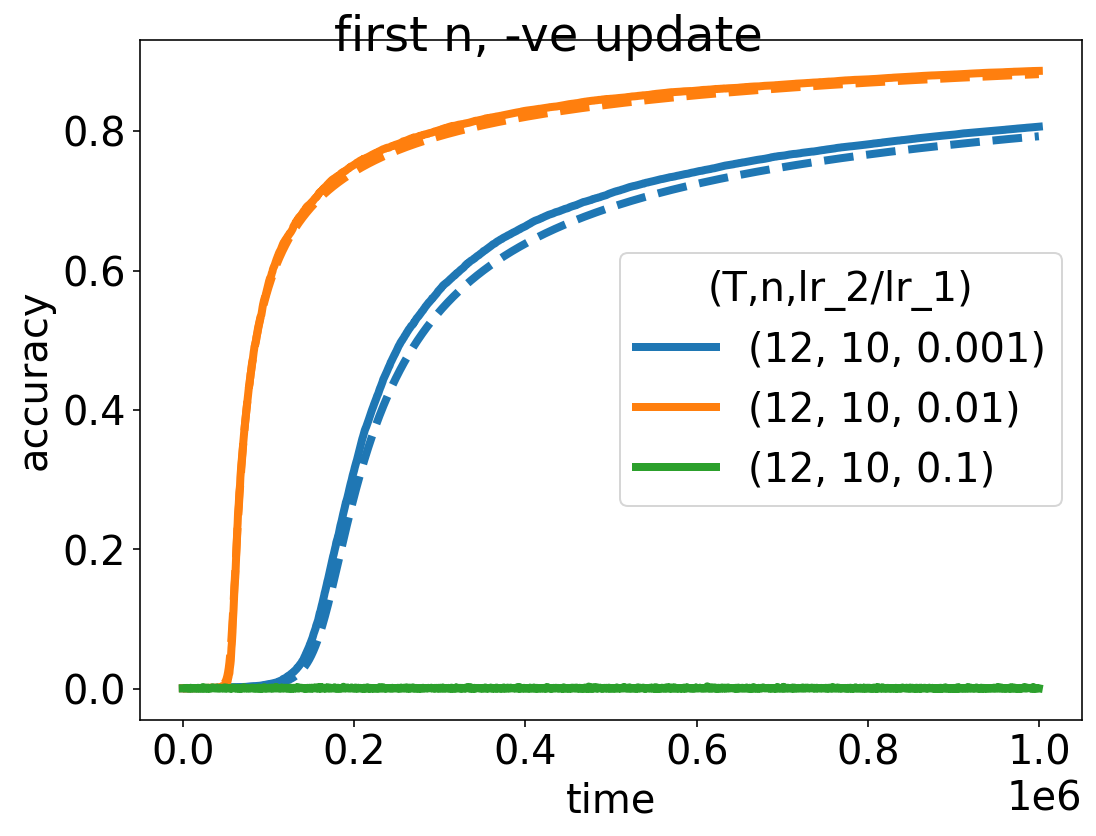

In [27]:
fig, ax = plt.subplots(figsize=(4 /3 * fig_size, fig_size))
fig.suptitle("first n, -ve update")
algo_idx = 0
for algo in Ts_2_neg:
    for n in ns_2_neg[algo]:
      for eta in etas_2:
        color = "C" + str(algo_idx)
        ax.plot(steps_rl_sim, accuracies_rl_sim_2_neg[(algo,n,eta)], label=(algo,n,eta), color=color)
        ax.plot(steps_rl_ode , accuracies_rl_ode_2_neg[(algo,n,eta)], "--", color=color)
        algo_idx += 1
ax.legend(title='(T,n,lr_2/lr_1)')
ax.set_xlabel("time")
ax.set_ylabel("accuracy")
# ax.set_ylim(top=1)
plt.tight_layout()
plt.show()

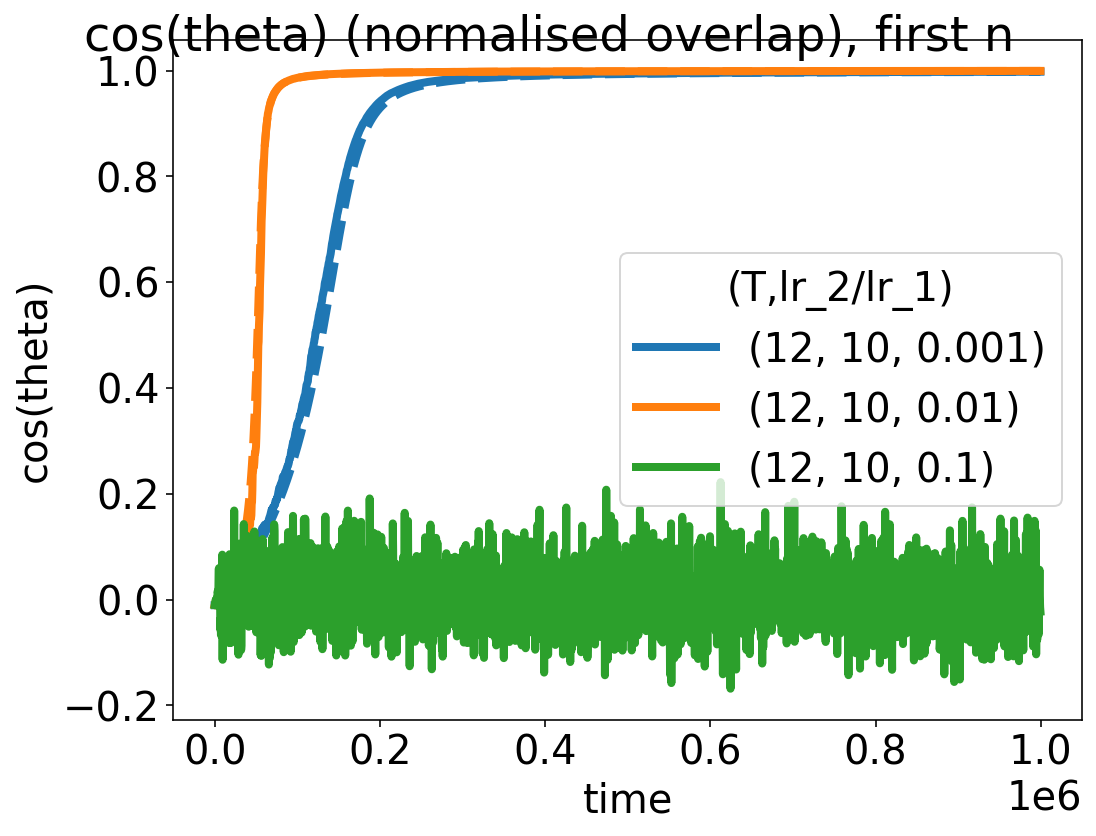

In [29]:
fig, ax = plt.subplots(figsize=(4 /3 * fig_size, fig_size))
fig.suptitle(f"cos(theta) (normalised overlap), first n")
algo_idx = 0
for algo in Ts_2_neg:
  for n in ns_2_neg[algo]:
    for eta in etas_2:
      color = "C" + str(algo_idx)
      r = np.array(R_rl_sim_2_neg[(algo,n,eta)])
      q = np.sqrt(np.array(Q_rl_sim_2_neg[(algo,n,eta)]))
      overlap = np.divide(r,q)
      r_t = np.array(R_rl_ode_2_neg[(algo,n,eta)])
      q_t = np.sqrt(np.array(Q_rl_ode_2_neg[(algo,n,eta)]))
      overlap_t = np.divide(r_t,q_t)
      ax.plot(steps_rl_sim, overlap, label=(algo,n,eta), color=color)
      ax.plot(steps_rl_ode, overlap_t, "--", color=color)
      algo_idx += 1
ax.legend(title='(T,lr_2/lr_1)')
ax.set_xlabel("time")
ax.set_ylabel("cos(theta)")
# ax.set_ylim(top=1)
plt.tight_layout()
plt.show()

In [59]:
"""
Experimentation with update rule: +ve update if n or more correct, -ve otherwise
"""
"""Ts = [3, 10]
ns = {3:[2,3], 10:[6,8,10]}"""

"""Ts_3_neg = [3,6,10,12]
ns_3_neg = {3:[2], 6:[4],10:[6,9],12:[7,10]}"""

Ts_3_neg = [12]
ns_3_neg = {12:[10]}
etas_3 = [0.9]

# student weight vectors
std0 = 1  # std dev of the initial student weights.


w_rl_student_3_neg = dict()

#vector perturbed from teacher vector
w_student_3 = w_teacher + 20*rnd.randn(D)

#vector perpendicular to teacher, perturbed towards teacher

"""w_student_3 = rnd.randn(D)
w_student_3 -= w_student_3 @ unit_teacher * unit_teacher
w_student_3 = np.sqrt(D) * w_student_3/np.linalg.norm(w_student_3)
w_student_3 += unit_teacher/np.sqrt(D)"""

#vector perpendicular to teacher, perturbed away from teacher
"""
w_student_3 = rnd.randn(D)
w_student_3 -= w_student_3 @ unit_teacher * unit_teacher
w_student_3 = np.sqrt(D) * w_student_3/np.linalg.norm(w_student_3)
w_student_3 -= unit_teacher/D
"""

#vector opposite to teacher, slightly perturbed
"""w_student_3 = -w_teacher + rnd.randn(D)/D"""

#random student
"""w_student_3 = rnd.randn(D)
"""

for T in Ts_3_neg:
    for n in ns_3_neg[T]:
      for eta in etas_3:
        w_rl_student_3_neg[(T,n,eta)] = w_student_3.copy()
    
# learning rates
lr_1 = 1

# make a copy of the initial conditions of the students for 
# later comparisons with the ODE integration
w_rl_init_3_neg = copy.deepcopy(w_rl_student_3_neg)

step = 0
num_steps = 1000 * D

steps_rl_sim = []
accuracies_rl_sim_3_neg = dict()
for T in Ts_3_neg:
    for n in ns_3_neg[T]:
      for eta in etas_3:
        accuracies_rl_sim_3_neg[(T,n,eta)] = []
R_rl_sim_3_neg = copy.deepcopy(accuracies_rl_sim_3_neg)
Q_rl_sim_3_neg = copy.deepcopy(accuracies_rl_sim_3_neg)

while step < num_steps:
    for T in Ts_3_neg:
        for n in ns_3_neg[T]:
          for eta in etas_3:
            lr_2 = eta
            # sample new input, output pair
            xs = rnd.randn(T, D)
            ys = np.sign(w_teacher @ xs.T)

            ypred = np.sign(w_rl_student_3_neg[(T,n,eta)] @ xs.T)

            test = ypred*ys +1
            reward = int(sum(test) >= 2*n) #this is the only differing line of code

            hebbian_update = np.mean(ypred[:, None] * xs, axis=0)

            w_rl_student_3_neg[(T,n,eta)] += lr_1 / np.sqrt(D) * reward * hebbian_update - lr_2 / np.sqrt(D) * (1-reward) * hebbian_update
    
    if step % D == 0:
      steps_rl_sim += [step]
      for T in Ts_3_neg:
        for n in ns_3_neg[T]:
          for eta in etas_3:
            correct = 0
            p = test_accuracy(w_rl_student_3_neg[(T,n,eta)], w_teacher, 1)
            for i in range(n,T+1):
              correct += scipy.special.binom(T,i) * p**i * (1-p)**(T-i)

            accuracies_rl_sim_3_neg[(T,n,eta)] += [correct]
            R_rl_sim_3_neg[(T,n,eta)] += [w_teacher @ w_rl_student_3_neg[(T,n,eta)] / D]
            Q_rl_sim_3_neg[(T,n,eta)] += [w_rl_student_3_neg[(T,n,eta)] @ w_rl_student_3_neg[(T,n,eta)] / D]
            
    step += 1

In [60]:
"""
ODEs for update rule: +ve update if n or more correct, -ve otherwise
"""
Q_3_neg = dict()
R_3_neg = dict()
w_3_neg = copy.deepcopy(w_rl_init_3_neg)

# Initial conditions for the order parameters
for T in Ts_3_neg:
  for n in ns_3_neg[T]:
    for eta in etas_3:
      Q_3_neg[(T,n,eta)] = w_rl_init_3_neg[(T,n,eta)] @ w_rl_init_3_neg[(T,n,eta)] / D
      R_3_neg[(T,n,eta)] = w_rl_init_3_neg[(T,n,eta)] @ w_teacher / D
    
# Integrate equations of motion
step = 0
steps_rl_ode = []
accuracies_rl_ode_3_neg = dict()
#accuracies_w_update_3 = dict()
for T in Ts_3_neg:
  for n in ns_3_neg[T]:
    for eta in etas_3:
      accuracies_rl_ode_3_neg[(T,n,eta)] = []
    #accuracies_w_update_3[(T,n)] = []
R_rl_ode_3_neg = copy.deepcopy(accuracies_rl_ode_3_neg)    
Q_rl_ode_3_neg = copy.deepcopy(accuracies_rl_ode_3_neg)
R_rl_3_neg = copy.deepcopy(accuracies_rl_ode_3_neg)
Q_rl_3_neg = copy.deepcopy(accuracies_rl_ode_3_neg)

dt = 1 / D

while step < num_steps:
    for T in Ts_3_neg:
      for n in ns_3_neg[T]:
        for eta in etas_3:
          lr_2 = eta
          # compute the probability that one, all-but-one, or all predictions were correct
          normalised_overlap = R_3_neg[(T,n,eta)]/W * np.sqrt(D/Q_3_neg[(T,n,eta)])
          p_correct = (1 - 1 / np.pi * np.arccos(normalised_overlap))
          
          #unit_student_2 = w_2[(T,n)]/np.linalg.norm(w_2[(T,n)])
          #phi_2 = (np.pi - np.arccos(unit_student_2 @ unit_teacher))/2
          phi_1 = (np.pi - np.arccos(normalised_overlap))/2

          theta = np.arccos(normalised_overlap)/2
          C_2 = np.sqrt(np.pi/2)*np.sin(theta)/theta

          C_1 = np.sqrt(np.pi/2)*np.sin(phi_1)/phi_1
          #C_2 = np.sqrt(np.pi/2)*np.sin(phi_2)/phi_2
          
          half_overlap = np.sqrt(1 + normalised_overlap)
          half_incorrect = np.sqrt(1 - normalised_overlap)

          a = 0
          b = 0

          c = 0
          d = 0
          e = 0

          for i in range(n,T+1):
            p_i = p_correct**i
            q_i = (1-p_correct)**(T-i)
            a += scipy.special.binom(T,i) * i * p_i * q_i
            b += scipy.special.binom(T,i) *(T-i) * p_i * q_i

            c += scipy.special.binom(T,i) * p_i * q_i
            d += scipy.special.binom(T,i) * i* (i-1) * p_i * q_i
            e += scipy.special.binom(T,i) * (T-i)* (T-i-1) * p_i * q_i


          dR = (lr_1 + lr_2)/(T*np.sqrt(D)) * (a*C_1*W/np.sqrt(2) * half_overlap - b*C_2*W/np.sqrt(2)*half_incorrect) - lr_2 *np.sqrt(2/(D*np.pi)) * W * normalised_overlap
          
          dQ = (2 * (lr_1 + lr_2)/(T*np.sqrt(D)) * (a*C_1*np.sqrt(D*Q_3_neg[(T,n,eta)]/2) * half_overlap + b*C_2*np.sqrt(D*Q_3_neg[(T,n,eta)]/2)*half_incorrect) + 
                (lr_1**2 - lr_2**2)/(T**2 *D) * (c*T*D + d*C_1**2 + e* C_2**2)) - 2*lr_2 * np.sqrt(2*Q_3_neg[(T,n,eta)]/np.pi) + lr_2**2/(T*D)*(D + (T-1)*2/np.pi)

          #dw = lr*np.sqrt(D)/T * test_accuracy(w_2[(T,n)], w_teacher, n) * (n*C_2*(unit_teacher + unit_student_2)/np.linalg.norm(unit_teacher + unit_student_2) + (T-n)*np.sqrt(np.pi/2)*unit_student_2)
          
          R_3_neg[(T,n,eta)] += dt * dR
          Q_3_neg[(T,n,eta)] += dt * dQ
          #w_2[(T,n)] += dt * dw
        
    if step % D == 0:
      steps_rl_ode += [step]
      for T in Ts_3_neg:
        for n in ns_3_neg[T]:
          for eta in etas_3:
            correct = 0
            p = test_accuracy_op(Q_3_neg[(T,n,eta)], R_3_neg[(T,n,eta)], 1)
            for i in range(n,T+1):
              correct += scipy.special.binom(T,i) * p**i * (1-p)**(T-i)

            accuracies_rl_ode_3_neg[(T,n,eta)].append(correct)
            #accuracies_w_update_2[(T,n)] += [test_accuracy(w_2[(T,n)], w_teacher, n)]
            #R_rl_2[(T,n)] += [w_teacher @ w_2[(T,n)] / D]
            #Q_rl_2[(T,n)] += [w_2[(T,n)] @ w_2[(T,n)] / D]
            R_rl_ode_3_neg[(T,n,eta)].append(R_3_neg[(T,n,eta)])
            Q_rl_ode_3_neg[(T,n,eta)].append(Q_3_neg[(T,n,eta)])

    step += 1

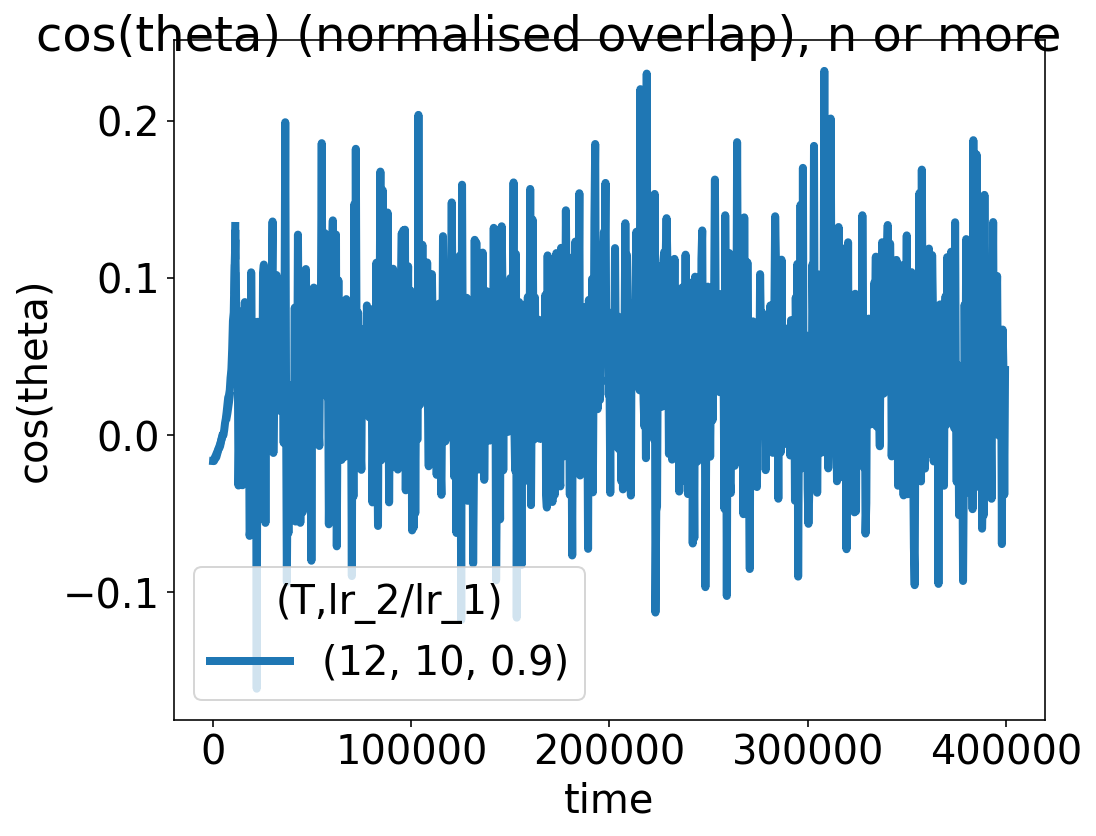

In [61]:
fig, ax = plt.subplots(figsize=(4 /3 * fig_size, fig_size))
fig.suptitle(f"cos(theta) (normalised overlap), n or more")
algo_idx = 0
for algo in Ts_3_neg:
  for n in ns_3_neg[algo]:
    for eta in etas_3:
      color = "C" + str(algo_idx)
      r = np.array(R_rl_sim_3_neg[(algo,n,eta)])
      q = np.sqrt(np.array(Q_rl_sim_3_neg[(algo,n,eta)]))
      overlap = np.divide(r,q)
      r_t = np.array(R_rl_ode_3_neg[(algo,n,eta)])
      q_t = np.sqrt(np.array(Q_rl_ode_3_neg[(algo,n,eta)]))
      overlap_t = np.divide(r_t,q_t)
      ax.plot(steps_rl_sim, overlap, label=(algo,n,eta), color=color)
      ax.plot(steps_rl_ode, overlap_t, "--", color=color)
      algo_idx += 1
ax.legend(title='(T,lr_2/lr_1)')
ax.set_xlabel("time")
ax.set_ylabel("cos(theta)")
# ax.set_ylim(top=1)
plt.tight_layout()
plt.show()

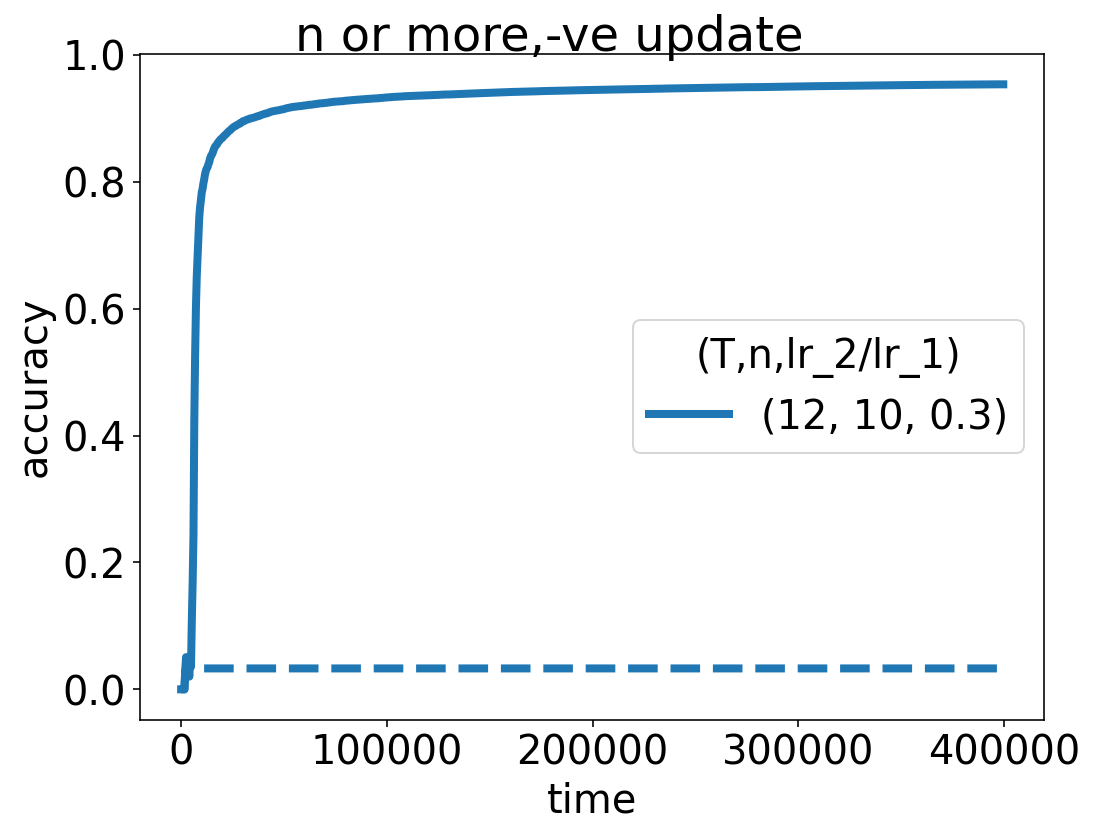

In [19]:
fig, ax = plt.subplots(figsize=(4 /3 * fig_size, fig_size))
fig.suptitle("n or more,-ve update")
algo_idx = 0
for algo in Ts_3_neg:
    for n in ns_3_neg[algo]:
      for eta in etas_3:
        color = "C" + str(algo_idx)
        ax.plot(steps_rl_sim, accuracies_rl_sim_3_neg[(algo,n,eta)], label=(algo,n,eta), color=color)
        ax.plot(steps_rl_ode , accuracies_rl_ode_3_neg[(algo,n,eta)], "--", color=color)
        algo_idx += 1
ax.legend(title='(T,n,lr_2/lr_1)')
ax.set_xlabel("time")
ax.set_ylabel("accuracy")
# ax.set_ylim(top=1)
plt.tight_layout()
plt.show()

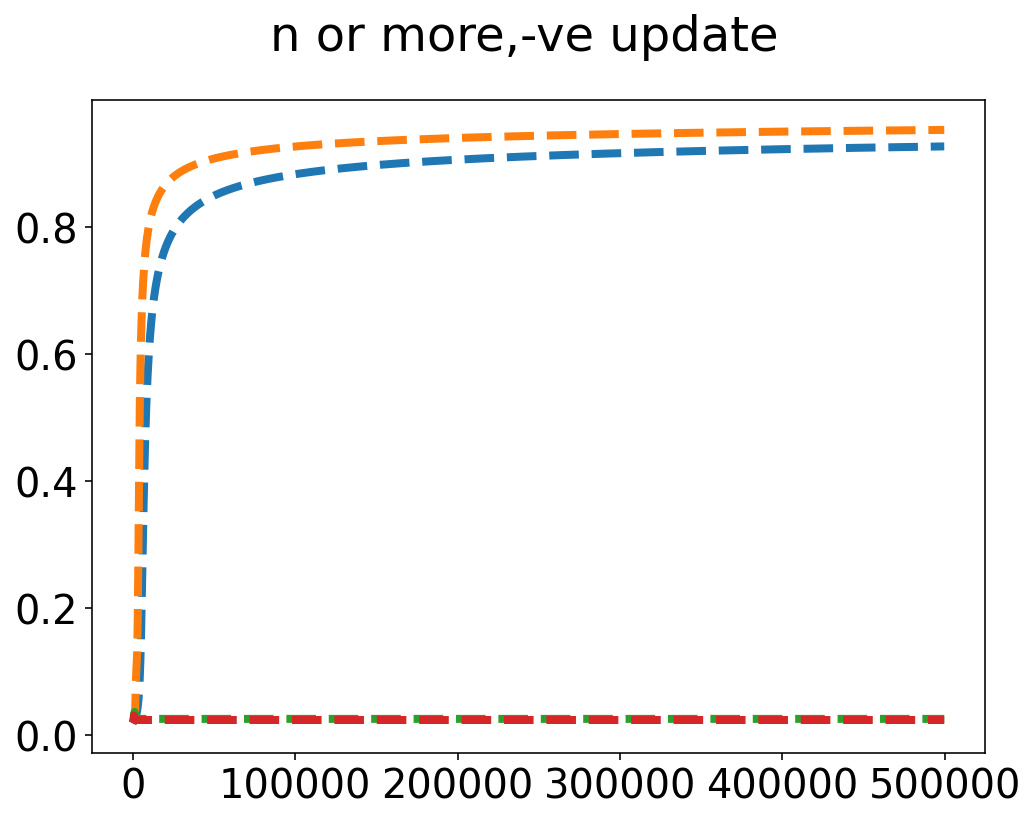

In [43]:
fig, ax = plt.subplots(figsize=(4 /3 * fig_size, fig_size))
fig.suptitle("n or more,-ve update")
algo_idx = 0
for eta in etas_3:
    color = "C" + str(algo_idx)
    ax.plot(steps_rl_ode , accuracies_rl_ode_3_neg[(algo,n,eta)], "--", color=color)
    algo_idx += 1

In [ ]:
"""
Experimentation: +ve reward if all correct, smaller reward if individual correct
"""

Ts = [10]
cs = [0.0001,0.0005,0.001,0.01]
# student weight vectors
std0 = 1  # std dev of the initial student weights.

w_rl_student = dict()
w_student = rnd.randn(D)
for T in Ts:
  for c in cs:
    w_rl_student[(T,c)] = w_student.copy()
    
# learning rates
lr_1 = 1

# make a copy of the initial conditions of the students for 
# later comparisons with the ODE integration
w_rl_init = copy.deepcopy(w_rl_student)

step = 0
num_steps = 1250 * D

steps_rl_sim = []
accuracies_rl_sim_neg = dict()
for T in Ts:
  for c in cs:
    accuracies_rl_sim_neg[(T,c)] = []
R_rl_sim_neg = copy.deepcopy(accuracies_rl_sim_neg)
Q_rl_sim_neg = copy.deepcopy(accuracies_rl_sim_neg)

while step < num_steps:
    for T in Ts:
      for c in cs:
        lr_2 = c
        # sample new input, output pair
        xs = rnd.randn(T, D)
        ys = np.sign(w_teacher @ xs.T)

        ypred = np.sign(w_rl_student[(T,c)] @ xs.T)

        reward_1 = lr_1 * np.all(ys == ypred)
        reward_2 = lr_2 * np.sum((ys * ypred + 1))/2
        reward = reward_1 + reward_2

        hebbian_update = np.mean(ys[:, None] * xs, axis=0)

        w_rl_student[(T,c)] += 1/ np.sqrt(D) * reward * hebbian_update
    
    if step % D == 0:
      steps_rl_sim += [step]
      for T in Ts:
        for c in cs:
          accuracies_rl_sim_neg[(T,c)] += [test_accuracy(w_rl_student[(T,c)], w_teacher, T)]
          R_rl_sim_neg[(T,c)] += [w_teacher @ w_rl_student[(T,c)] / D]
          Q_rl_sim_neg[(T,c)] += [w_rl_student[(T,c)] @ w_rl_student[(T,c)] / D]
            
    step += 1

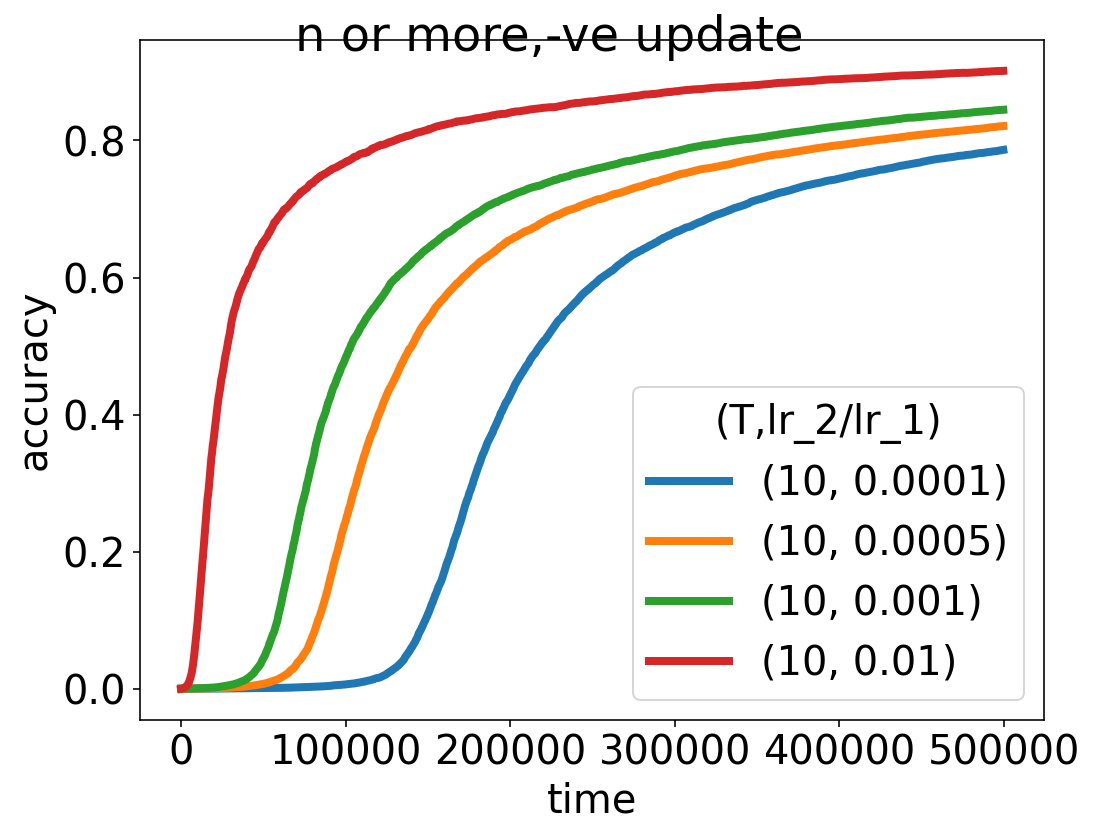

In [ ]:
fig, ax = plt.subplots(figsize=(4 /3 * fig_size, fig_size))
fig.suptitle("n or more,-ve update")
algo_idx = 0
for algo in Ts:
    for c in cs:
      color = "C" + str(algo_idx)
      ax.plot(steps_rl_sim, accuracies_rl_sim_neg[(algo,c)], label=(algo,c), color=color)
      algo_idx += 1
ax.legend(title='(T,lr_2/lr_1)')
ax.set_xlabel("time")
ax.set_ylabel("accuracy")
# ax.set_ylim(top=1)
plt.tight_layout()
plt.show()

In [ ]:
"""
ODEs:  +ve reward if all correct, -ve otherwise
"""
Q_neg = dict()
R_neg = dict()
w = copy.deepcopy(w_rl_init)

# Initial conditions for the order parameters
for T in Ts:
  for c in cs:
    Q_neg[(T,c)] = w_rl_init[(T,c)] @ w_rl_init[(T,c)] / D
    R_neg[(T,c)] = w_rl_init[(T,c)] @ w_teacher / D
    
# Integrate equations of motion
step = 0
steps_rl_ode = []
accuracies_rl_ode_neg = dict()
for T in Ts:
  for c in cs:
    accuracies_rl_ode_neg[(T,c)] = []
R_rl_ode_neg = copy.deepcopy(accuracies_rl_ode_neg)    
Q_rl_ode_neg = copy.deepcopy(accuracies_rl_ode_neg)

dt = 1 / D

while step < num_steps:
    for T in Ts:
      for c in cs:
        lr_2 = c
        # compute the probability that one, all-but-one, or all predictions were correct
        normalised_overlap = R_neg[(T,c)]/W * np.sqrt(D/Q_neg[(T,c)])
        p_correct = (1 - 1 / np.pi * np.arccos(R_neg[(T,c)] / W *np.sqrt(D/Q_neg[(T,c)])))
        p_correct_all = p_correct**T
        #unit_student = w[T]/np.linalg.norm(w[T])
        #phi_2 = (np.pi - np.arccos(unit_student@unit_teacher))/2
        phi_1 = (np.pi - np.arccos(R_neg[(T,c)] / W *np.sqrt(D/Q_neg[(T,c)])))/2

        C_1 = np.sqrt(np.pi/2)*np.sin(phi_1)/phi_1
        #C_2 = np.sqrt(np.pi/2)*np.sin(phi_2)/phi_2
        
        half_overlap = np.sqrt(1 + R_neg[(T,c)]/W * np.sqrt(D/Q_neg[(T,c)]))

        dR = lr_1 * W*C_1/np.sqrt(2*D) * p_correct_all * half_overlap + lr_2/np.sqrt(D) *( W*C_1/np.sqrt(2) * half_overlap + (T-1)*np.sqrt(2/np.pi)*normalised_overlap*W)*p_correct
        
        dQ = 2*lr_1 * C_1*np.sqrt(Q_neg[(T,c)]/(2)) * p_correct_all * half_overlap + 2*lr_2 *(C_1*np.sqrt(Q_neg[(T,c)]/2) * half_overlap + (T-1)*np.sqrt(2*Q_neg[(T,c)]/(np.pi)))*p_correct
        
       (lr_1**2/(T*D) + 2*lr_1 * lr_2/D) *(D + (T-1)*2/np.pi)*p_correct_all + 
        
        #dw = lr * np.sqrt(D)*C_2*test_accuracy(w[T], w_teacher, T) * (unit_teacher + unit_student)/np.linalg.norm(unit_teacher + unit_student)
        
        
        R_neg[(T,c)] += dt * dR
        Q_neg[(T,c)] += dt * dQ
        #w[T] += dt * dw
        
    if step % D == 0:
      steps_rl_ode += [step]
      for T in Ts:
        for c in cs:
          accuracies_rl_ode_neg[(T,c)] += [test_accuracy_op(Q_neg[(T,c)], R_neg[(T,c)], T)]
          #accuracies_w_update[T] += [test_accuracy(w[T], w_teacher, T)]
          R_rl_ode_neg[(T,c)] += [R_neg[(T,c)]]
          Q_rl_ode_neg[(T,c)] += [Q_neg[(T,c)]]
    step += 1